In [5]:
# !pip install poutyne
# !pip install wget
# !pip install opencv-python    

   ---------------------------------------- 0.0/213.5 kB ? eta -:--:--
   --------------------------------------- 213.5/213.5 kB 12.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/805.2 kB ? eta -:--:--
   --------------------------------------- 805.2/805.2 kB 25.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=e3722d58faf16b239c68af2a4cfc03c0a441a77664fd4a40030b0c2c524be526
  Stored in directory: c:\users\saori\appdata\local\pip\cache\wheels\40\b3\0f\a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [1]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wget
import zipfile
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, StepLR
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid

In [3]:
batch_size = 64
image_size = 224
w, h = 218, 178  # the width and the hight of original images before resizing
set_seeds(48)
gender_index = 20  # in the CelebA dataset gender information is the 21th item in the attributes vector.
imagenet_mean = [0.485, 0.456, 0.406]  # mean of the ImageNet dataset for normalizing
imagenet_std = [0.229, 0.224, 0.225]  # std of the ImageNet dataset for normalizing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The running processor is...", device)

The running processor is... cuda


In [4]:
data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_root}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

100% [..........................................................................] 2836386 / 2836386

In [5]:
transforms = tfms.Compose(
    [
        tfms.Resize((image_size, image_size)),
        tfms.ToTensor(),
        tfms.Normalize(imageneta_mean, imagenet_std),
    ]
)
train_dataset = datasets.CelebA(data_root, split="train", target_type=["attr"], transform=transforms)
valid_dataset = datasets.CelebA(data_root, split="valid", target_type=["attr"], transform=transforms)
test_dataset = datasets.CelebA(data_root, split="test", target_type=["attr"], transform=transforms)

In [6]:
train_num = 5000
train_ratio = 0.7

train_subset = Subset(train_dataset, np.arange(1, int(train_num*train_ratio)))
valid_subset = Subset(valid_dataset, np.arange(1, int(train_num*(1-train_ratio))))
test_subset = Subset(test_dataset, np.arange(1, 1000))
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [7]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=2):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes

        # Create the CNN model
        model = getattr(models, model_name)(pretrained=True)

        if model_name == "resnet18":
            # Modify the final fully connected layer for ResNet
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, num_classes)
        elif model_name == "alexnet":
            # Modify the last fully connected layer for AlexNet
            num_features = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_features, num_classes)
        elif model_name == "vgg16":
            # Modify the last fully connected layer for VGG16
            num_features = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_features, num_classes)
        else:
            raise ValueError("Unsupported model_name. Supported values are 'resnet', 'alexnet', and 'vgg16'.")

        self.model = model

    def forward(self, x):
        x = self.model(x)  # Extract features from CNN
        scores = x[:, : self.num_classes]  # Class scores
        return scores  # Output class scores

In [8]:
class ClassificationRegressionLoss(nn.Module):
    def __init__(self):
        super(ClassificationRegressionLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()  # size_average=False

    def forward(self, y_pred, y_true):
        loss_cls = self.ce_loss(y_pred, y_true[:, gender_index])  # Cross Entropy Error (for classification)
        return loss_cls

In [34]:
network_list = [ 'resnet18', 'alexnet']
# network_list = ['vgg16']
learning_rate_list = [0.01,0.005,0.001]
optimizer_list = ['SGD','RMSprop', 'Adam'] # 'SGD'
momentum_list = [0.0, 0.2, 0.4]

In [40]:
loss_function = ClassificationRegressionLoss()

for network_name in network_list:
  network = ClassifierLocalizer(model_name=network_name)

  for optimizer_name in optimizer_list:
    for learning_rate in learning_rate_list:
      for momentum in momentum_list:
        if optimizer_name == 'SGD':
          optimizer = optim.SGD(network.parameters(), lr=learning_rate)
        elif optimizer_name == 'RMSprop':
          optimizer = optim.RMSprop(network.parameters(), lr=learning_rate)
        elif optimizer_name == 'Adam':
          optimizer = optim.Adam(network.parameters(), lr=learning_rate)

        save_directory_path = f"C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/{network_name}_{optimizer_name}_{momentum}_{learning_rate}"

        exp = Experiment(
            save_directory_path,
            network,
            optimizer=optimizer,
            loss_function=loss_function,
            device=device,
        )
        exp.train(train_dataloader, valid_dataloader, epochs=30)

          
        # Remove files other than logs (that writes the losses for each epochs), as too much space taken up
        if os.path.exists(save_directory_path) and os.path.isdir(save_directory_path):
            # Get the name of the parent folder
            parent_folder_name = os.path.basename(save_directory_path)
        
            # Get the list of files and folders in the directory
            items = os.listdir(save_directory_path)
        
            # Iterate through the items in the directory
            for item in items:
                item_path = os.path.join(save_directory_path, item)
        
                # Check if the item is 'log.tsv'
                if item == 'log.tsv':
                    pass
                else:
                    if os.path.isfile(item_path):
                        # If it's a file (other than 'log.tsv'), remove it
                        os.remove(item_path)
                    elif os.path.isdir(item_path):
                        # If it's a directory, remove it and its contents
                        shutil.rmtree(item_path)

C:\Users\saori\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\saori\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Python311\Lib\site-packages\poutyne\framework\model_bundle.py:751: UserWarning: tensorboard does not seem to be installed. To remove this warning, set the 'disable_tensorboard' flag to True or install tensorboard.
  return self._train(self.model.fit_generator, train_generator, valid_generator, **kwargs)


Epoch:  1/30 Train steps: 55 Val steps: 24 1m55.39s loss: 0.378533 val_loss: 0.253973
Epoch 1: val_loss improved from inf to 0.25397, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/model_training_network_resnet18_optimizer_SGD_momentum_0.0_learning_rate0.005\checkpoint_epoch_1.ckpt
Epoch:  2/30 Train steps: 55 Val steps: 24 1m54.94s loss: 0.198530 val_loss: 0.167485
Epoch 2: val_loss improved from 0.25397 to 0.16748, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/model_training_network_resnet18_optimizer_SGD_momentum_0.0_learning_rate0.005\checkpoint_epoch_2.ckpt
Epoch:  3/30 Train steps: 55 Val steps: 24 1m55.48s loss: 0.143126 val_loss: 0.140952
Epoch 3: val_loss improved from 0.16748 to 0.14095, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn

C:\Python311\Lib\site-packages\poutyne\framework\model_bundle.py:751: UserWarning: tensorboard does not seem to be installed. To remove this warning, set the 'disable_tensorboard' flag to True or install tensorboard.
  return self._train(self.model.fit_generator, train_generator, valid_generator, **kwargs)


Epoch:  1/30 Train steps: 55 Val steps: 24 1m55.47s loss: 0.017795 val_loss: 0.108005
Epoch 1: val_loss improved from inf to 0.10801, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/model_training_network_resnet18_optimizer_SGD_momentum_0.2_learning_rate0.005\checkpoint_epoch_1.ckpt
Epoch:  2/30 Train steps: 55 Val steps: 24 1m55.53s loss: 0.014153 val_loss: 0.106771
Epoch 2: val_loss improved from 0.10801 to 0.10677, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/model_training_network_resnet18_optimizer_SGD_momentum_0.2_learning_rate0.005\checkpoint_epoch_2.ckpt
Epoch:  3/30 Train steps: 55 Val steps: 24 1m55.55s loss: 0.012647 val_loss: 0.107447
Epoch:  4/30 Train steps: 55 Val steps: 24 1m55.50s loss: 0.010033 val_loss: 0.107610
Epoch:  5/30 Train steps: 55 Val steps: 24 1m55.47s loss: 0.008089 val_loss: 0.106835
Epoc

C:\Python311\Lib\site-packages\poutyne\framework\model_bundle.py:751: UserWarning: tensorboard does not seem to be installed. To remove this warning, set the 'disable_tensorboard' flag to True or install tensorboard.
  return self._train(self.model.fit_generator, train_generator, valid_generator, **kwargs)


Epoch:  1/30 Train steps: 55 Val steps: 24 1m55.46s loss: 0.011768 val_loss: 0.107460
Epoch 1: val_loss improved from inf to 0.10746, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/model_training_network_resnet18_optimizer_SGD_momentum_0.4_learning_rate0.005\checkpoint_epoch_1.ckpt
Epoch:  2/30 Train steps: 55 Val steps: 24 1m55.37s loss: 0.010081 val_loss: 0.108406
Epoch:  3/30 Train steps: 55 Val steps: 24 1m55.39s loss: 0.010361 val_loss: 0.107687
Epoch:  4/30 Train steps: 55 Val steps: 24 1m55.34s loss: 0.008317 val_loss: 0.108538
Epoch:  5/30 Train steps: 55 Val steps: 24 1m55.38s loss: 0.006557 val_loss: 0.107729
Epoch:  6/30 Train steps: 55 Val steps: 24 1m55.29s loss: 0.005957 val_loss: 0.108147
Epoch:  7/30 Train steps: 55 Val steps: 24 1m55.21s loss: 0.005229 val_loss: 0.109735
Epoch:  8/30 Train steps: 55 Val steps: 24 1m55.27s loss: 0.005362 val_loss: 0.109558
Epoch:  9/30 Train steps: 55 Va

C:\Python311\Lib\site-packages\poutyne\framework\model_bundle.py:751: UserWarning: tensorboard does not seem to be installed. To remove this warning, set the 'disable_tensorboard' flag to True or install tensorboard.
  return self._train(self.model.fit_generator, train_generator, valid_generator, **kwargs)


Epoch:  1/30 Train steps: 55 Val steps: 24 1m58.50s loss: 0.009362 val_loss: 0.106987
Epoch 1: val_loss improved from inf to 0.10699, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/model_training_network_resnet18_optimizer_SGD_momentum_0.0_learning_rate0.001\checkpoint_epoch_1.ckpt
Epoch:  2/30 Train steps: 55 Val steps: 24 1m55.37s loss: 0.009921 val_loss: 0.109246
Epoch:  3/30 Train steps: 55 Val steps: 24 1m55.40s loss: 0.011038 val_loss: 0.106215
Epoch 3: val_loss improved from 0.10699 to 0.10622, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/model_training_network_resnet18_optimizer_SGD_momentum_0.0_learning_rate0.001\checkpoint_epoch_3.ckpt
Epoch:  4/30 Train steps: 55 Val steps: 24 1m55.44s loss: 0.009365 val_loss: 0.108495
Epoch:  5/30 Train steps: 55 Val steps: 24 1m55.32s loss: 0.008156 val_loss: 0.106758
Epoc

C:\Python311\Lib\site-packages\poutyne\framework\model_bundle.py:751: UserWarning: tensorboard does not seem to be installed. To remove this warning, set the 'disable_tensorboard' flag to True or install tensorboard.
  return self._train(self.model.fit_generator, train_generator, valid_generator, **kwargs)


Epoch:  1/30 Train steps: 55 Val steps: 24 1m55.46s loss: 0.008261 val_loss: 0.106695
Epoch 1: val_loss improved from inf to 0.10670, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/model_training_network_resnet18_optimizer_SGD_momentum_0.2_learning_rate0.001\checkpoint_epoch_1.ckpt
Epoch:  2/30 Train steps: 55 Val steps: 24 1m55.39s loss: 0.008687 val_loss: 0.109244
Epoch:  3/30 Train steps: 55 Val steps: 24 1m55.45s loss: 0.009514 val_loss: 0.106375
Epoch 3: val_loss improved from 0.10670 to 0.10637, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/model_training_network_resnet18_optimizer_SGD_momentum_0.2_learning_rate0.001\checkpoint_epoch_3.ckpt
Epoch:  4/30 Train steps: 55 Val steps: 24 1m55.40s loss: 0.008193 val_loss: 0.108766
Epoch:  5/30 Train steps: 55 Val steps: 24 1m55.51s loss: 0.007092 val_loss: 0.107146
Epoc

C:\Python311\Lib\site-packages\poutyne\framework\model_bundle.py:751: UserWarning: tensorboard does not seem to be installed. To remove this warning, set the 'disable_tensorboard' flag to True or install tensorboard.
  return self._train(self.model.fit_generator, train_generator, valid_generator, **kwargs)


Epoch:  1/30 Train steps: 55 Val steps: 24 1m55.25s loss: 0.007755 val_loss: 0.106804
Epoch 1: val_loss improved from inf to 0.10680, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/model_training_network_resnet18_optimizer_SGD_momentum_0.4_learning_rate0.001\checkpoint_epoch_1.ckpt
Epoch:  2/30 Train steps: 55 Val steps: 24 1m55.29s loss: 0.008104 val_loss: 0.109610
Epoch:  3/30 Train steps: 55 Val steps: 24 1m58.74s loss: 0.008741 val_loss: 0.106603
Epoch 3: val_loss improved from 0.10680 to 0.10660, saving file to C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/model_training_network_resnet18_optimizer_SGD_momentum_0.4_learning_rate0.001\checkpoint_epoch_3.ckpt
Epoch:  4/30 Train steps: 55 Val steps: 24 1m58.26s loss: 0.007800 val_loss: 0.109031
Epoch:  5/30 Train steps: 55 Val steps: 24 1m55.44s loss: 0.006705 val_loss: 0.107394
Epoc

C:\Users\saori\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\saori\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


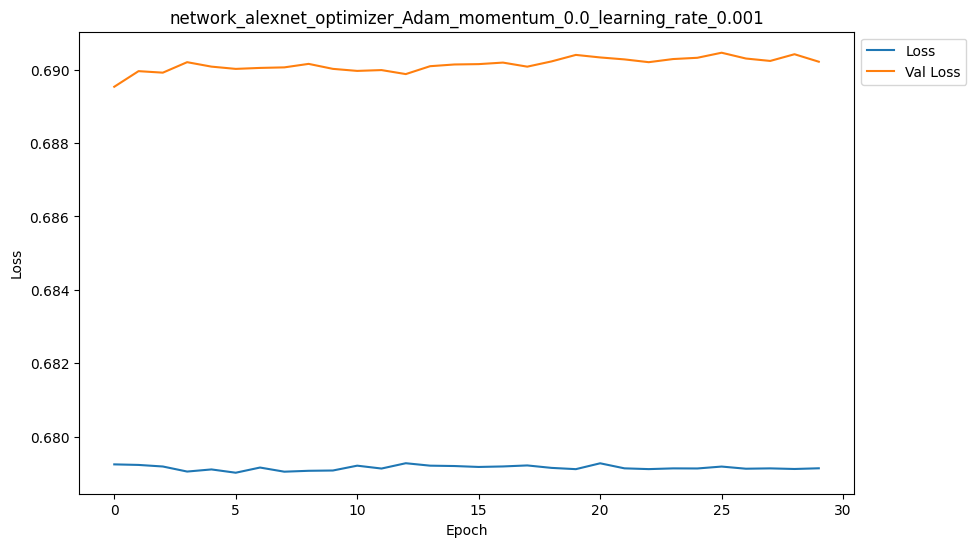

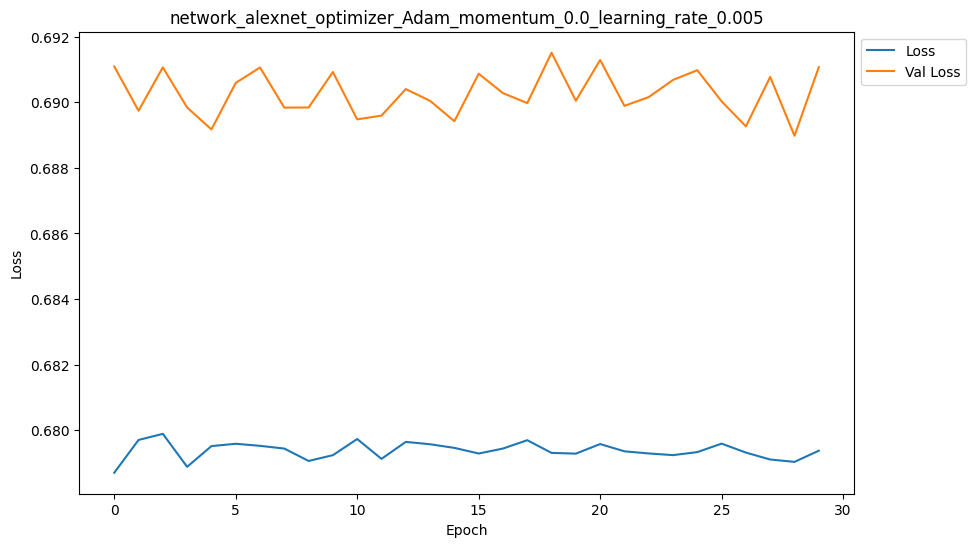

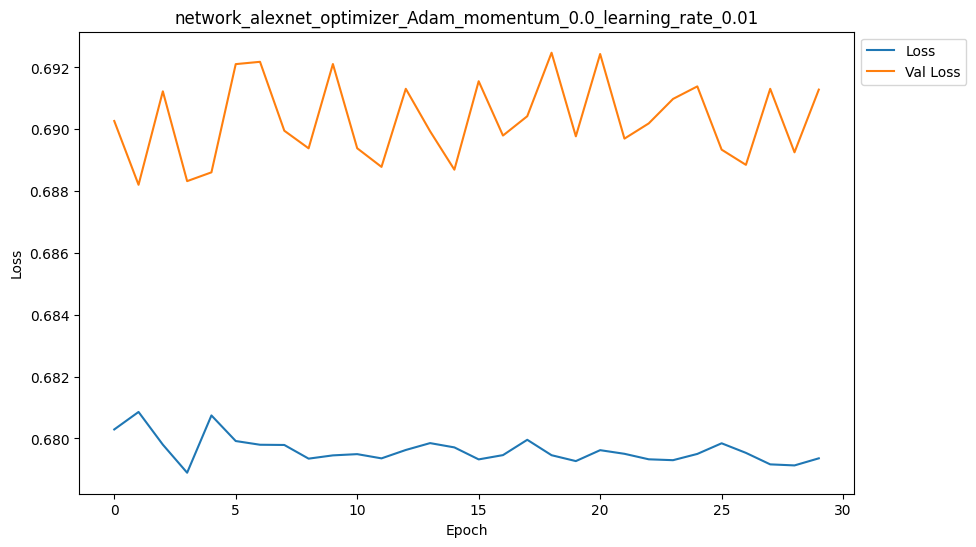

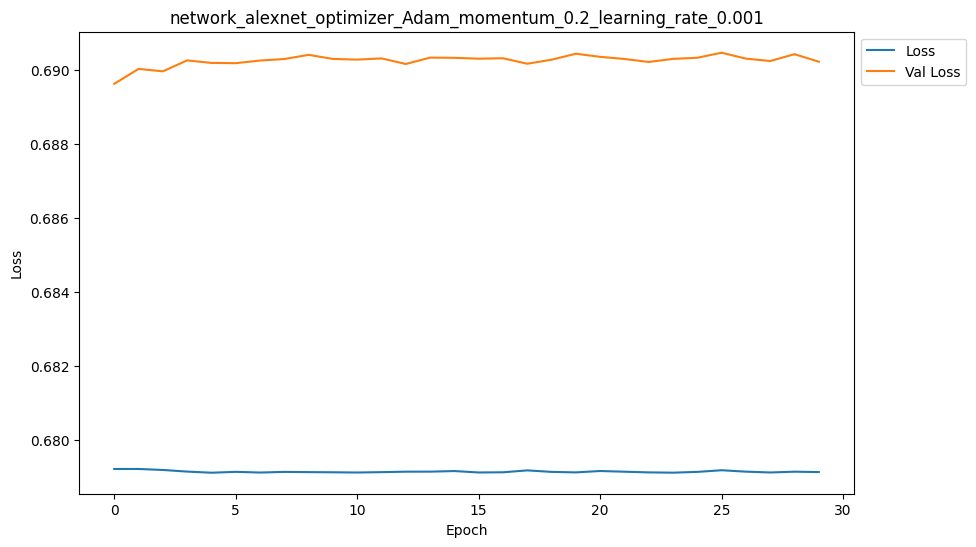

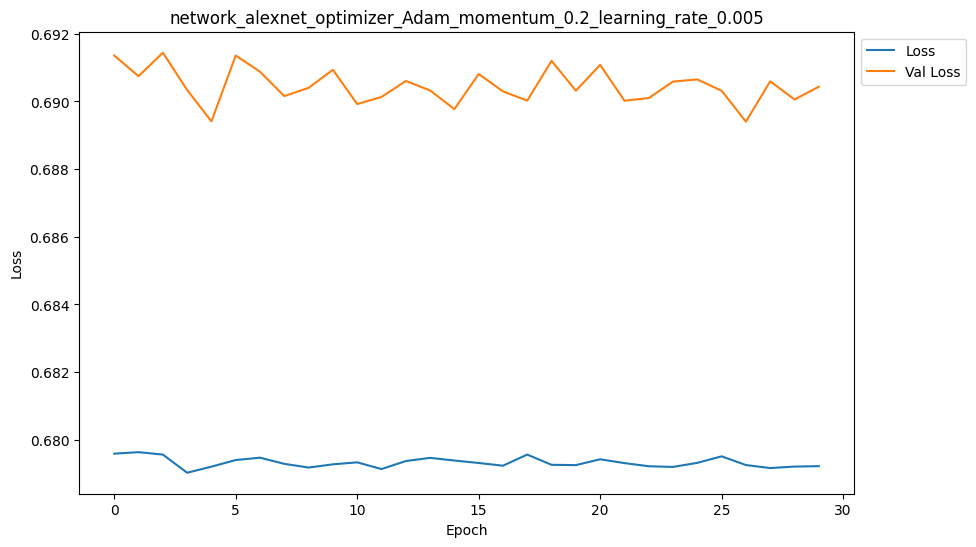

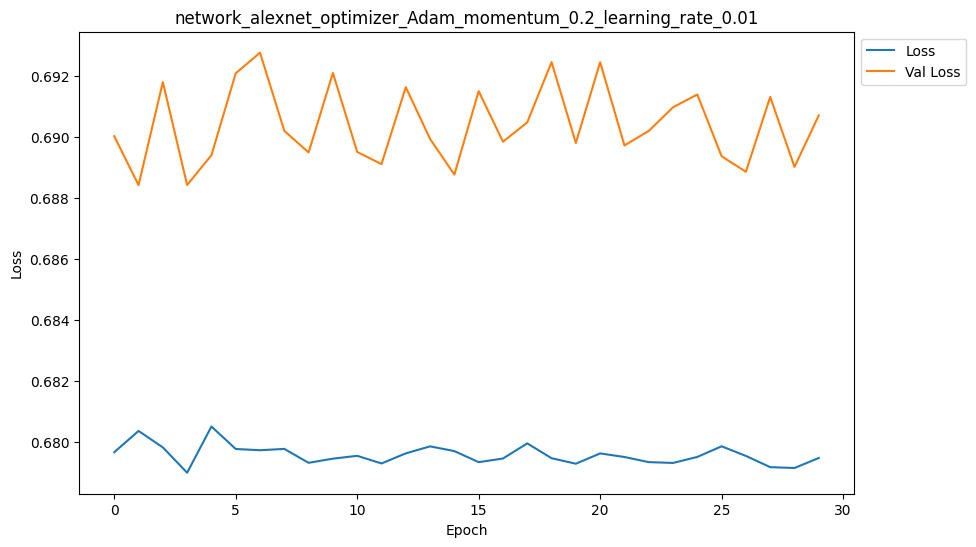

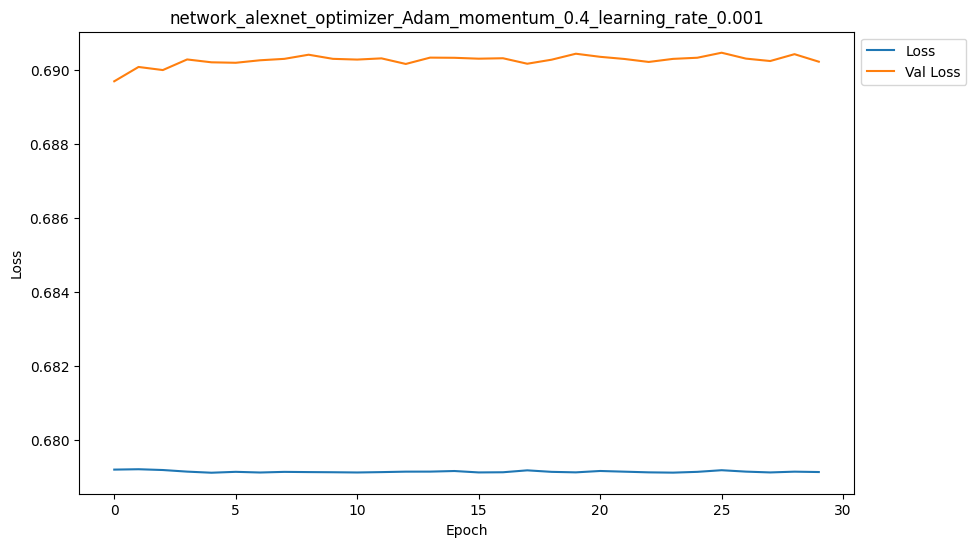

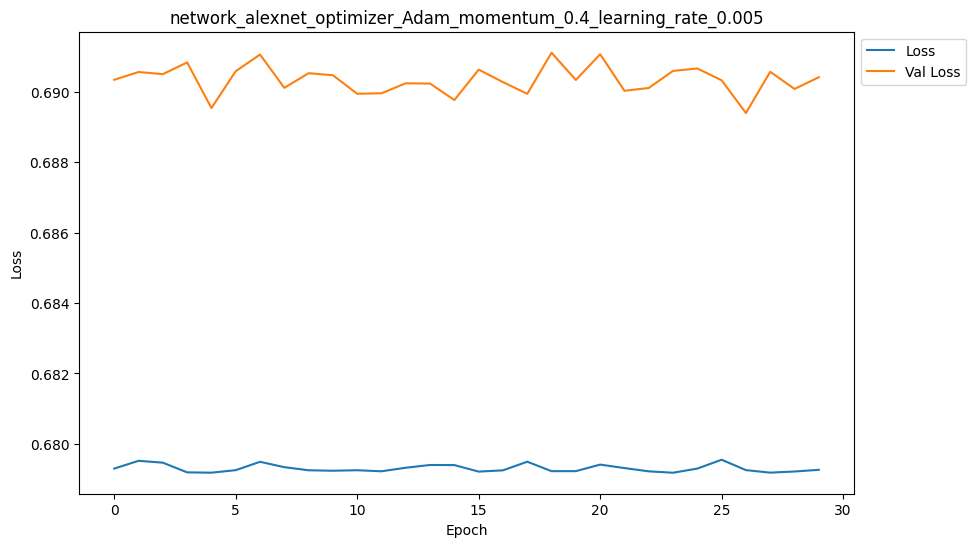

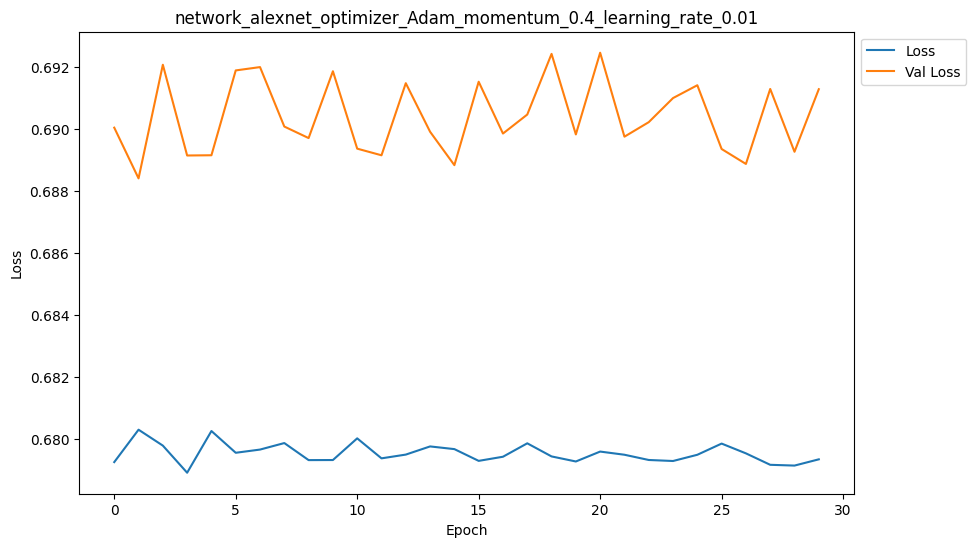

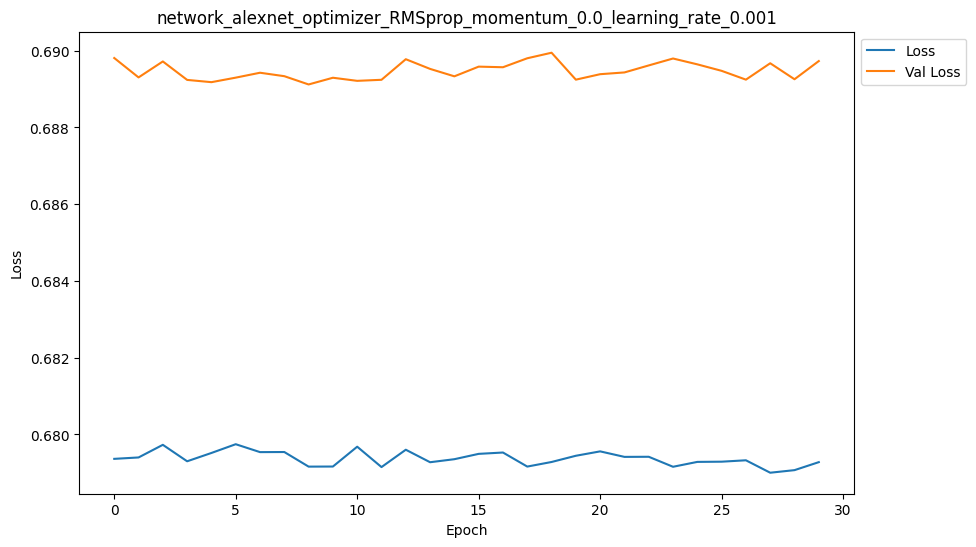

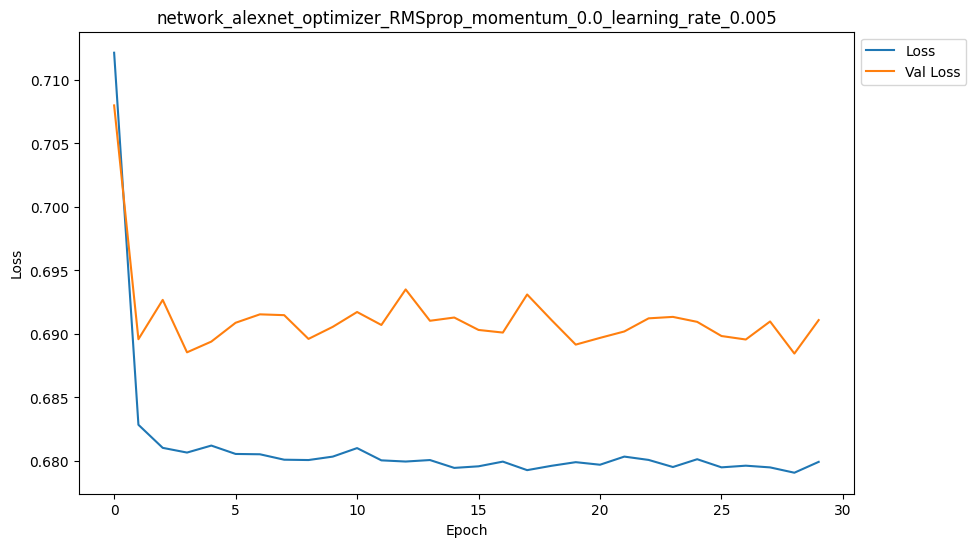

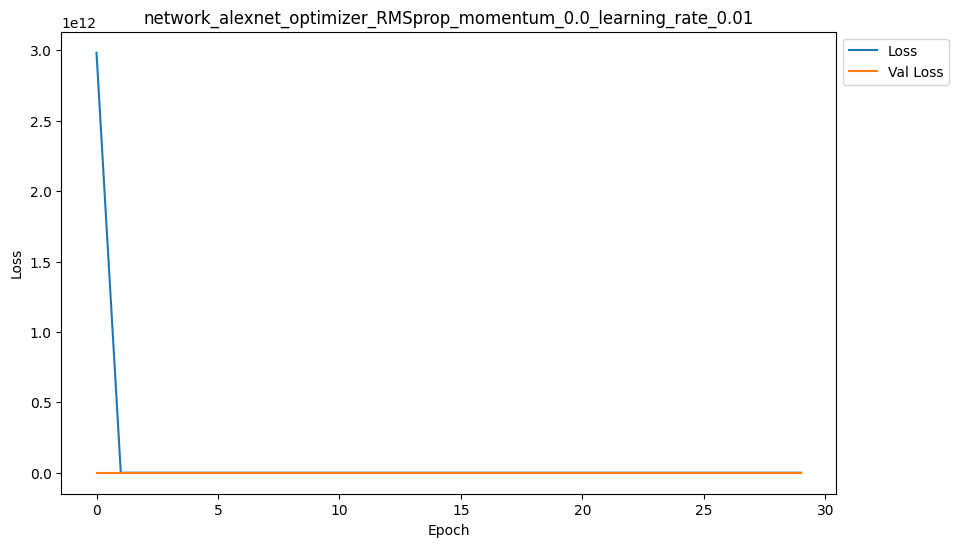

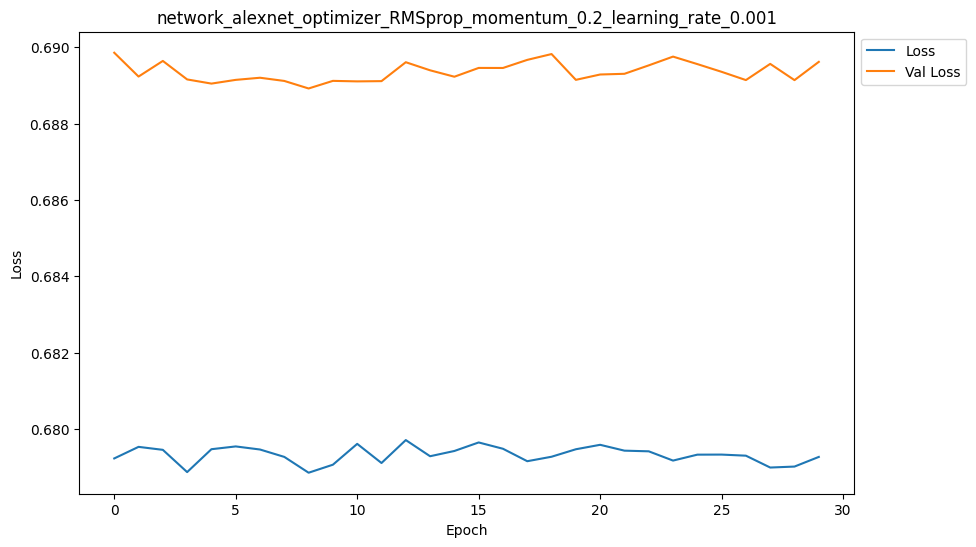

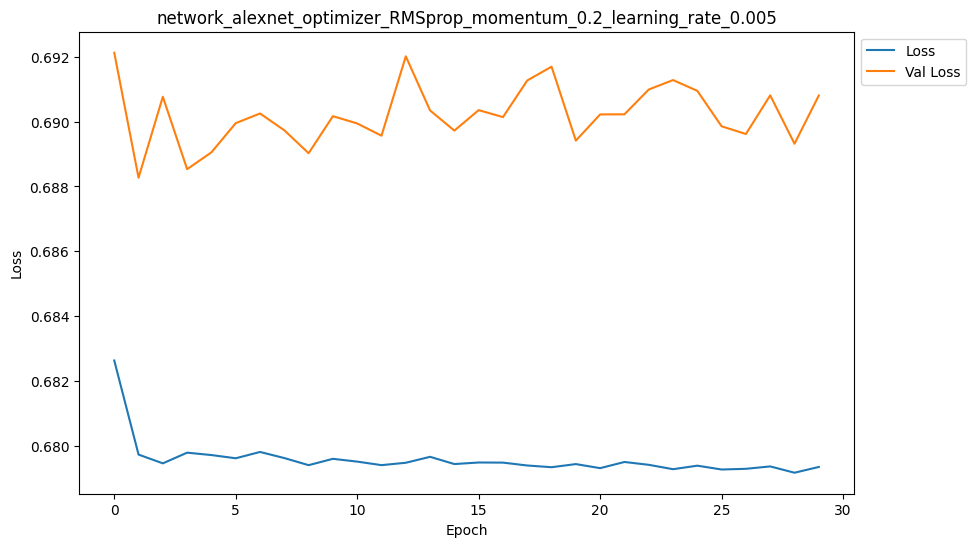

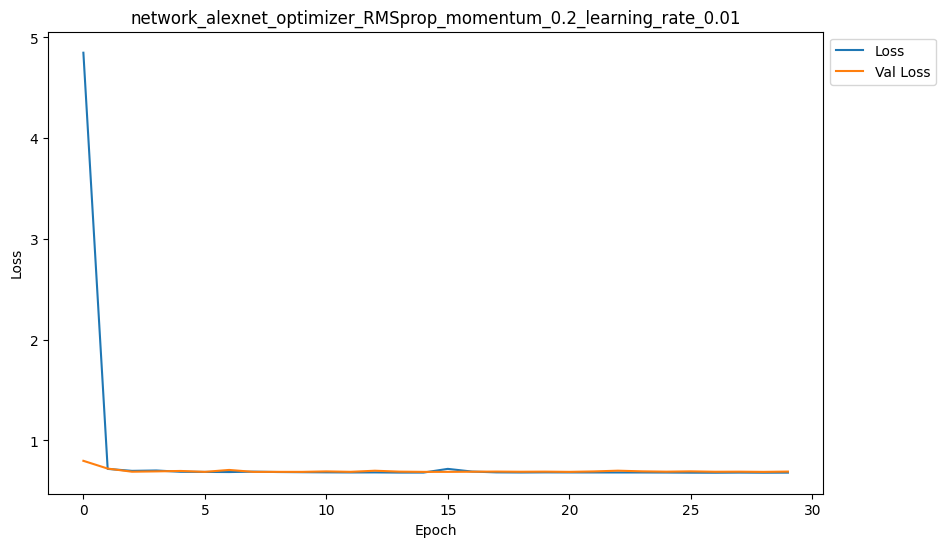

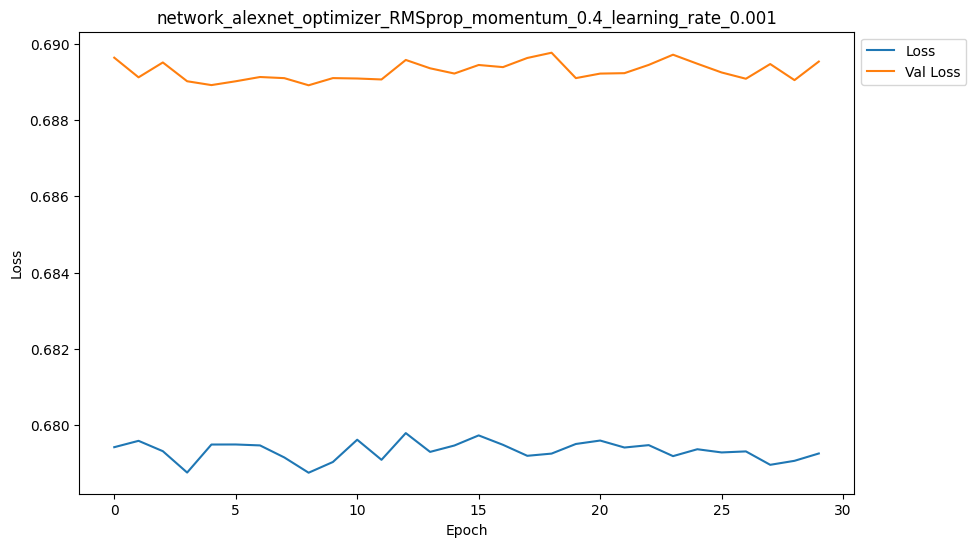

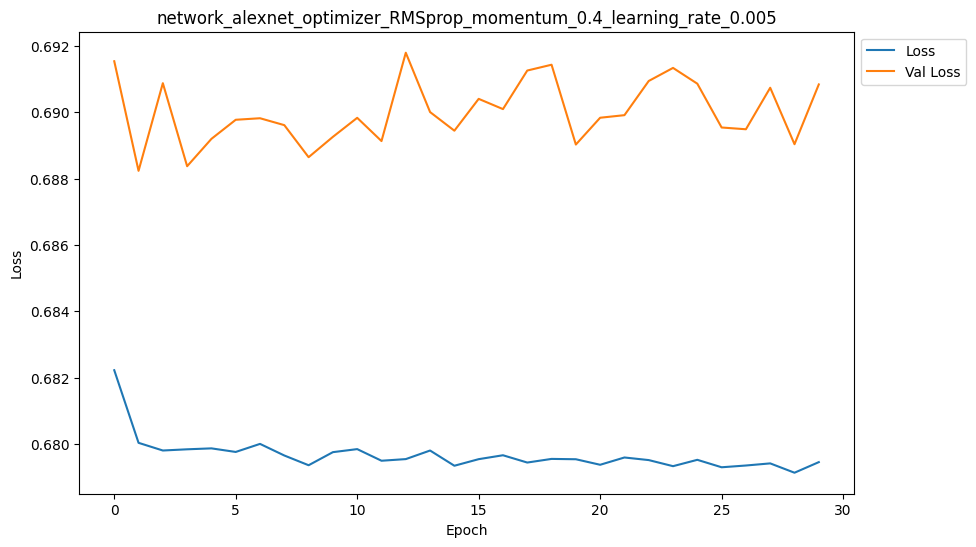

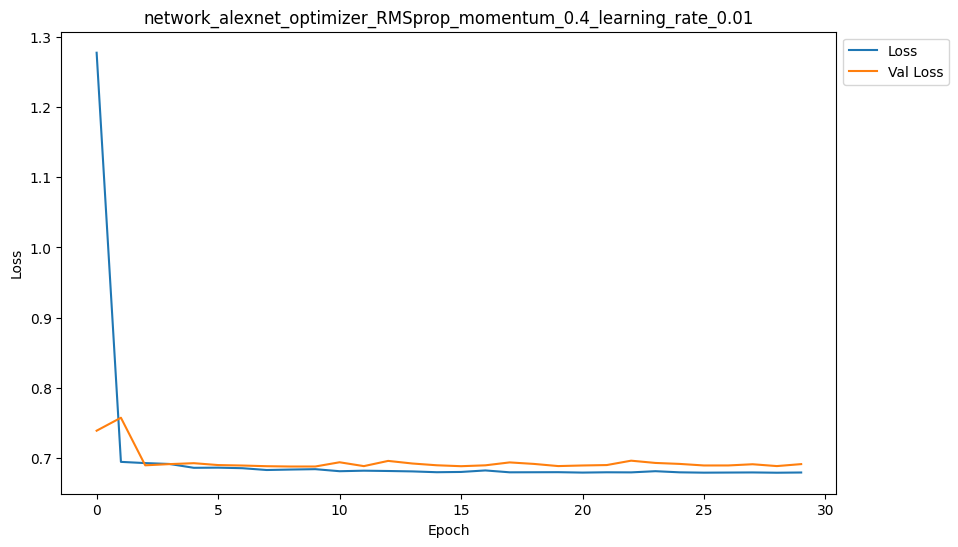

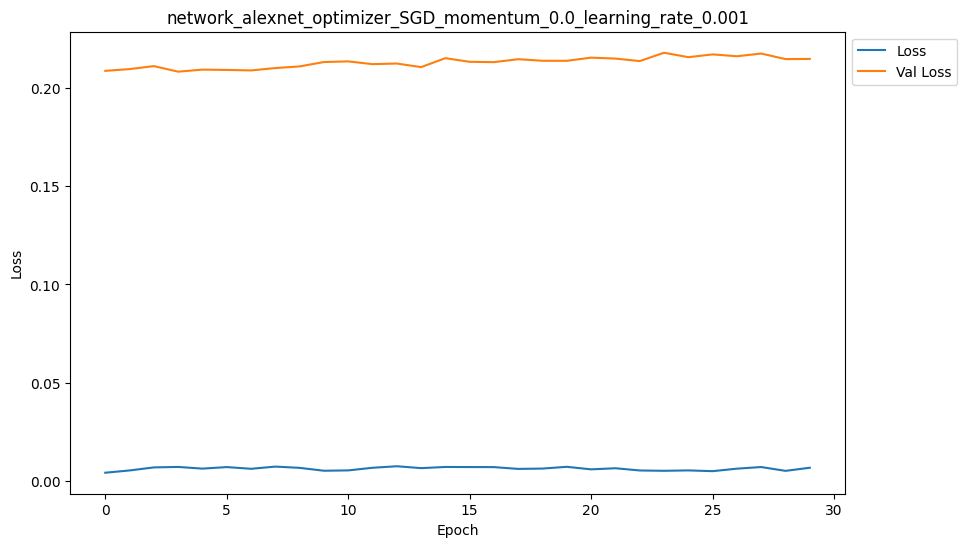

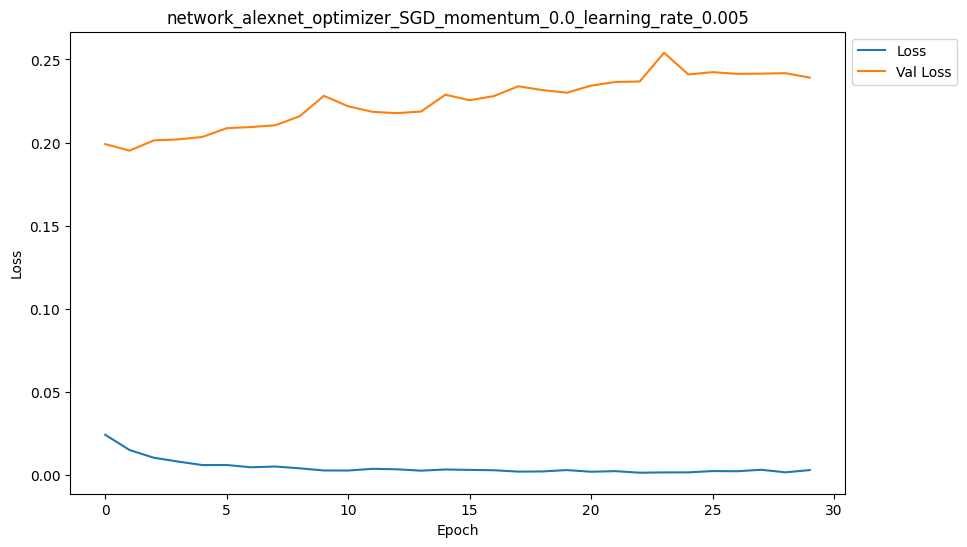

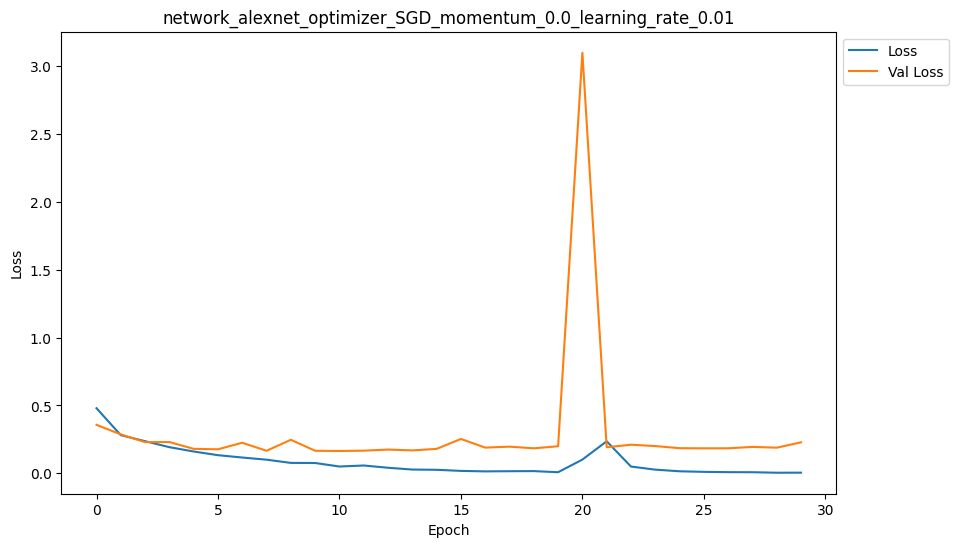

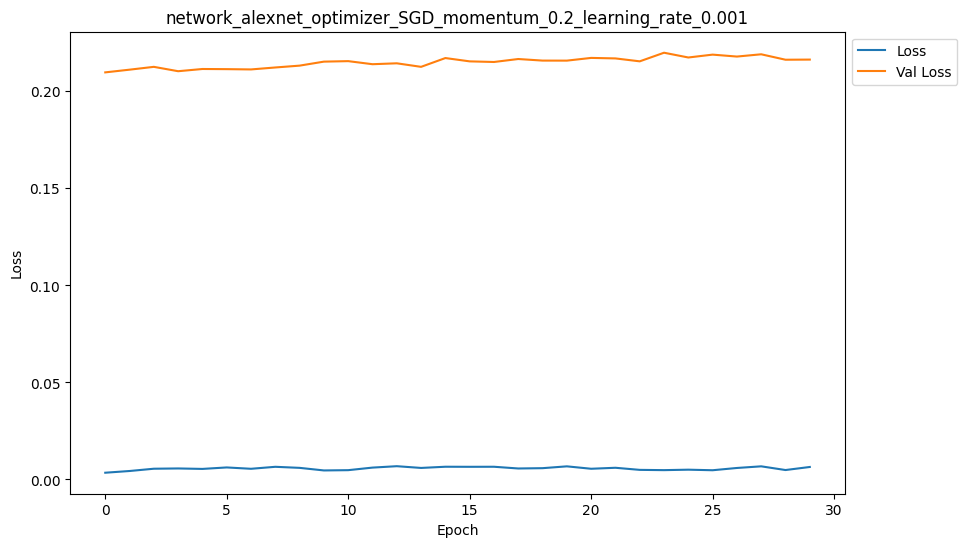

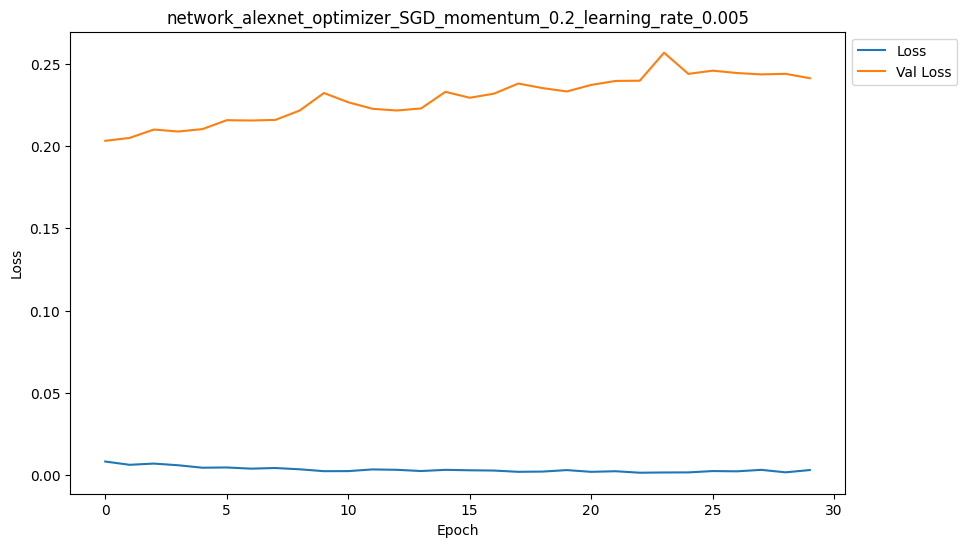

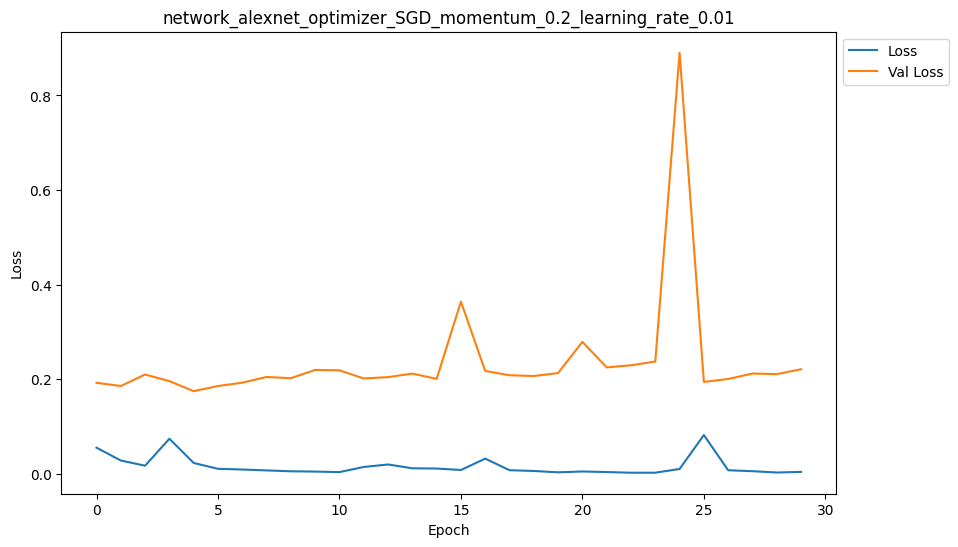

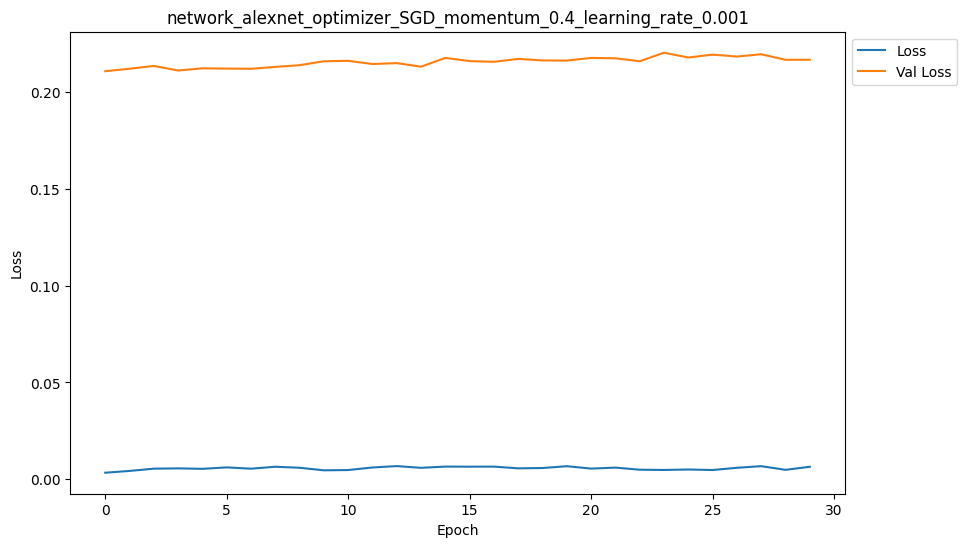

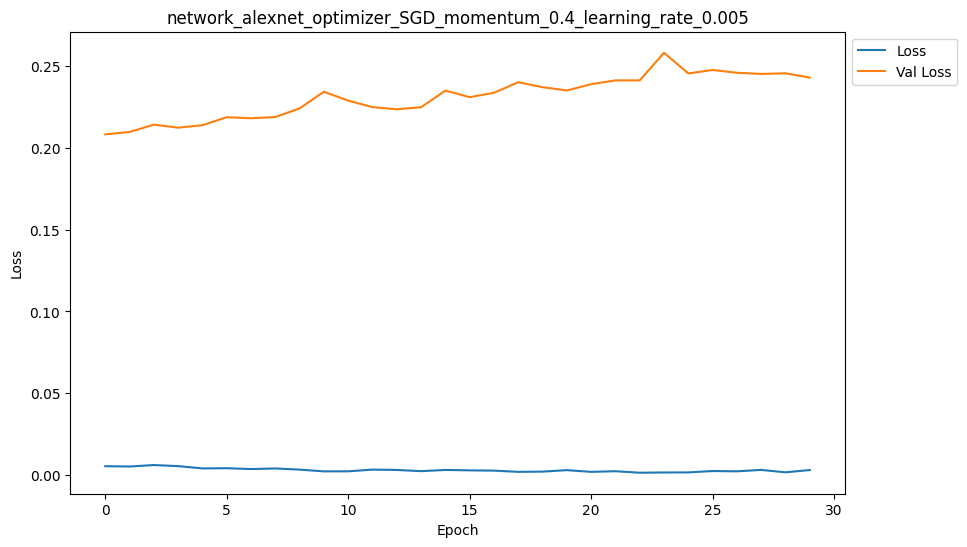

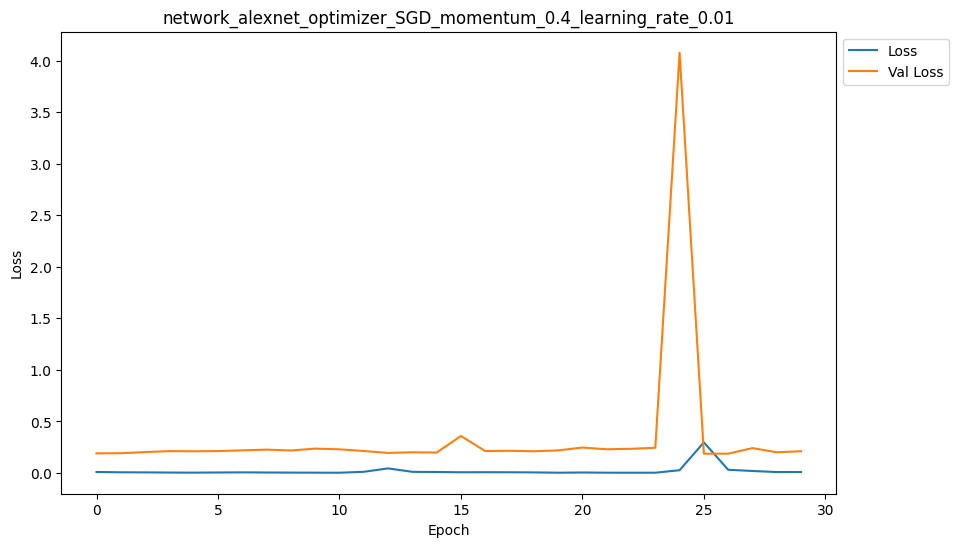

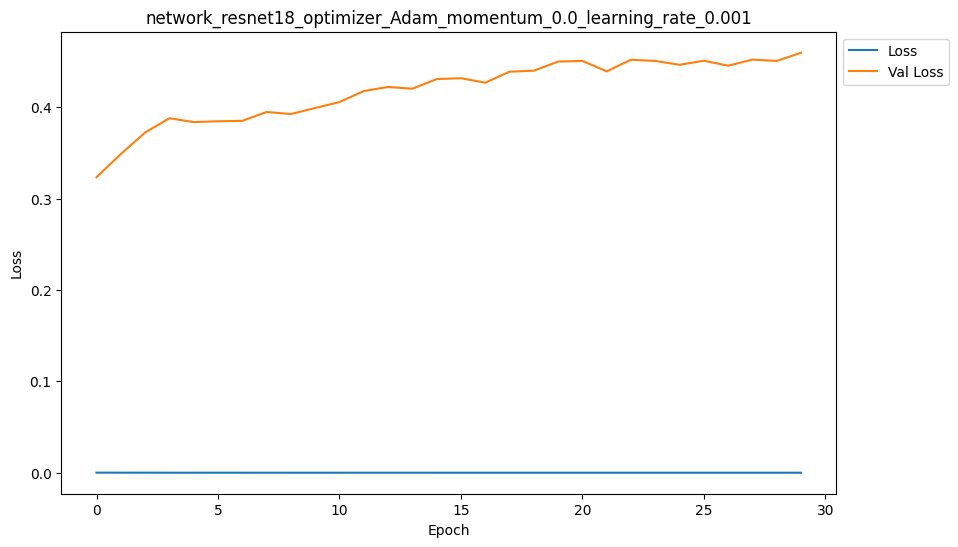

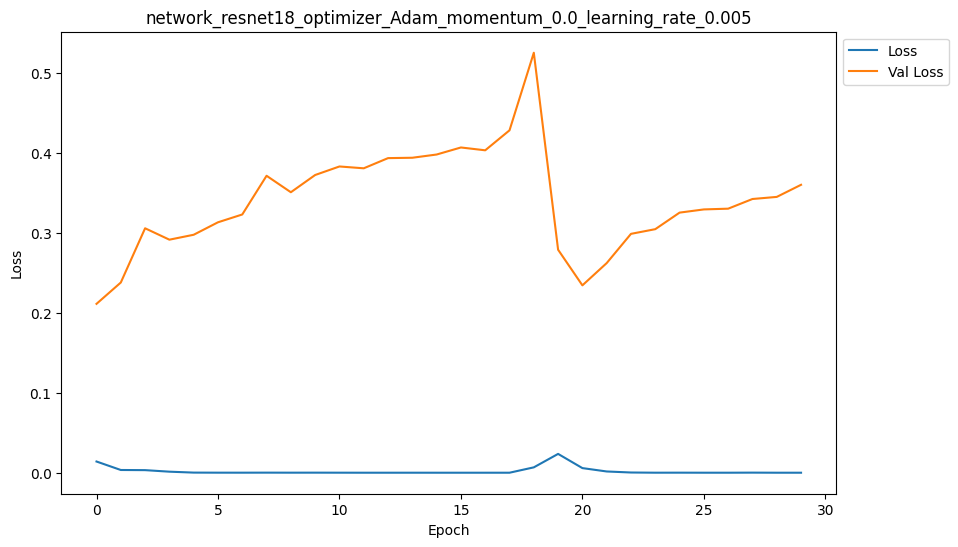

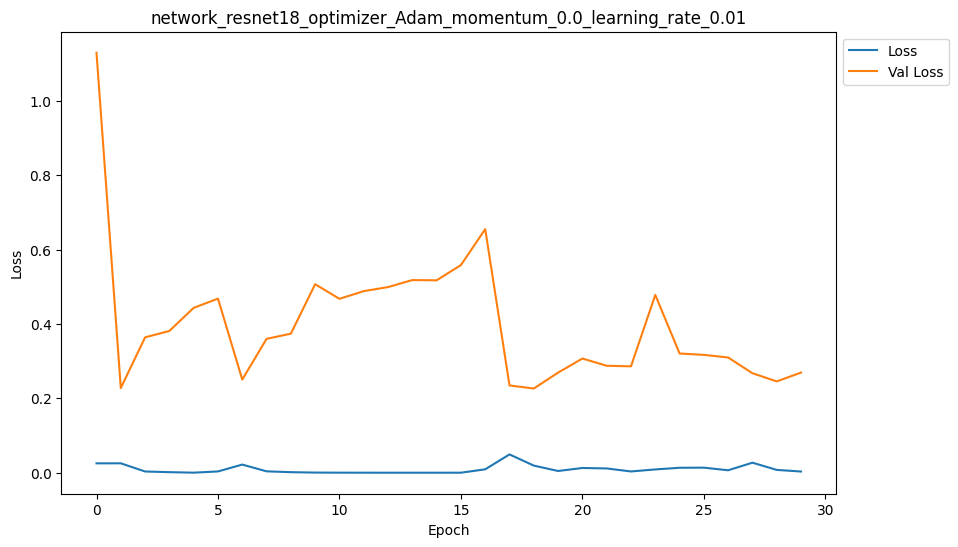

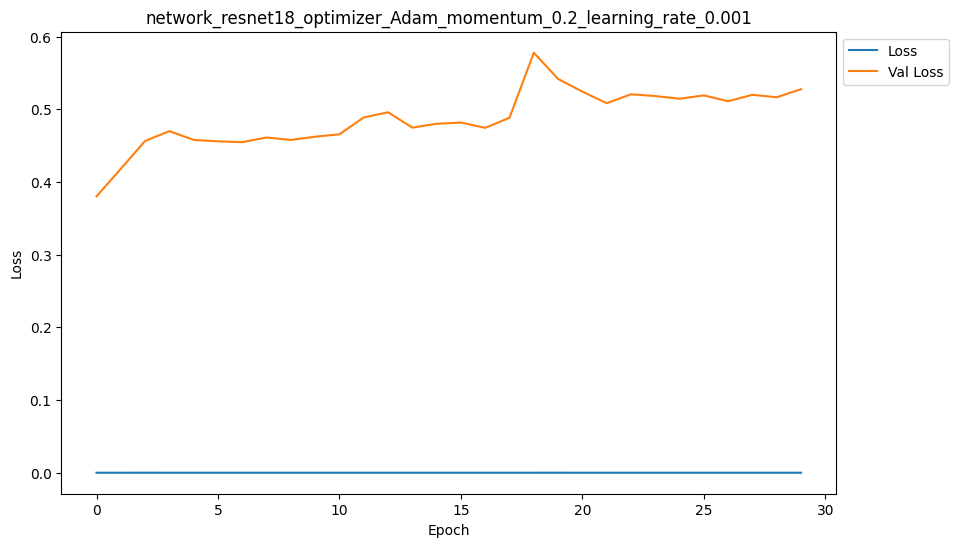

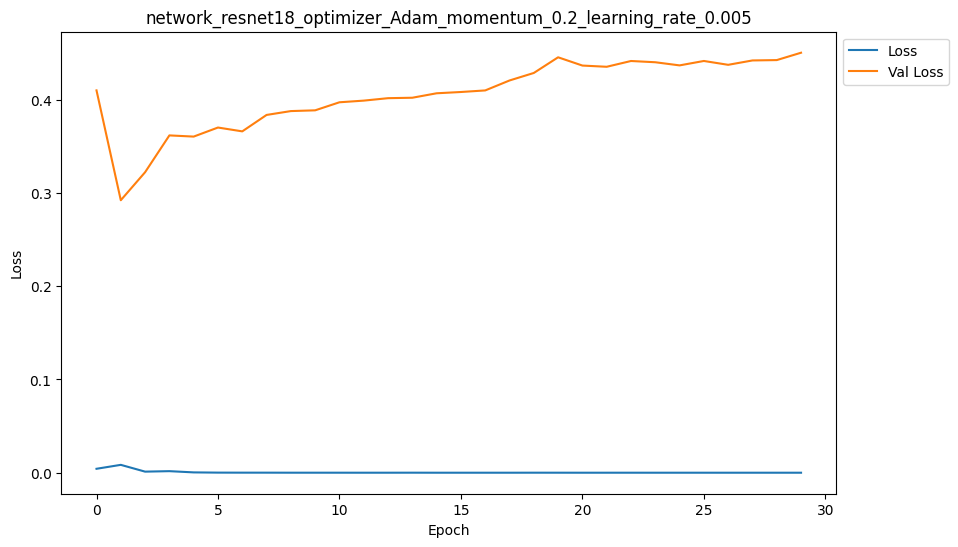

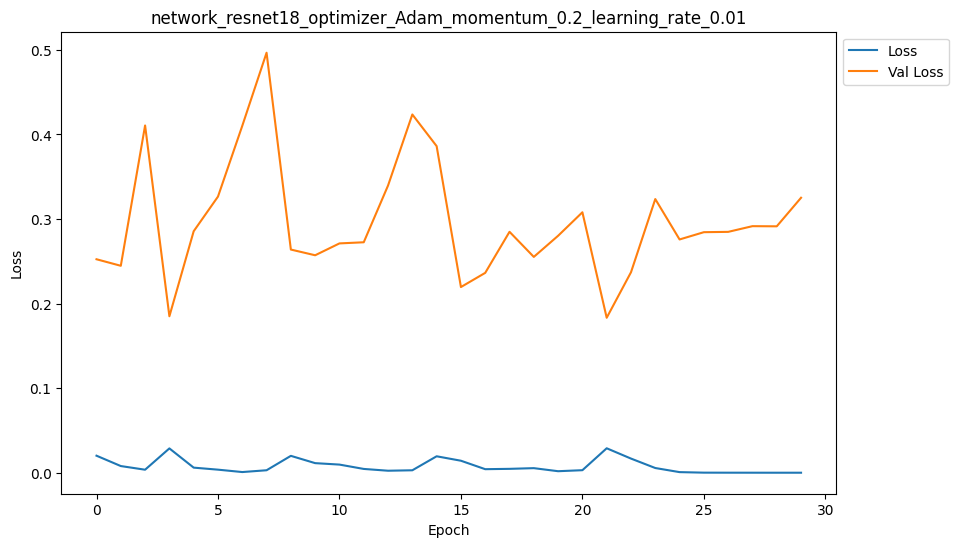

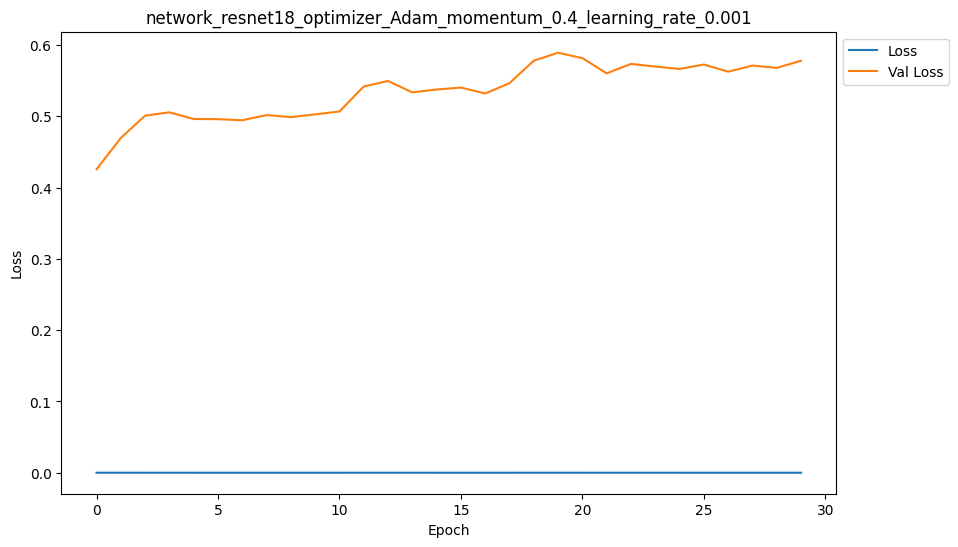

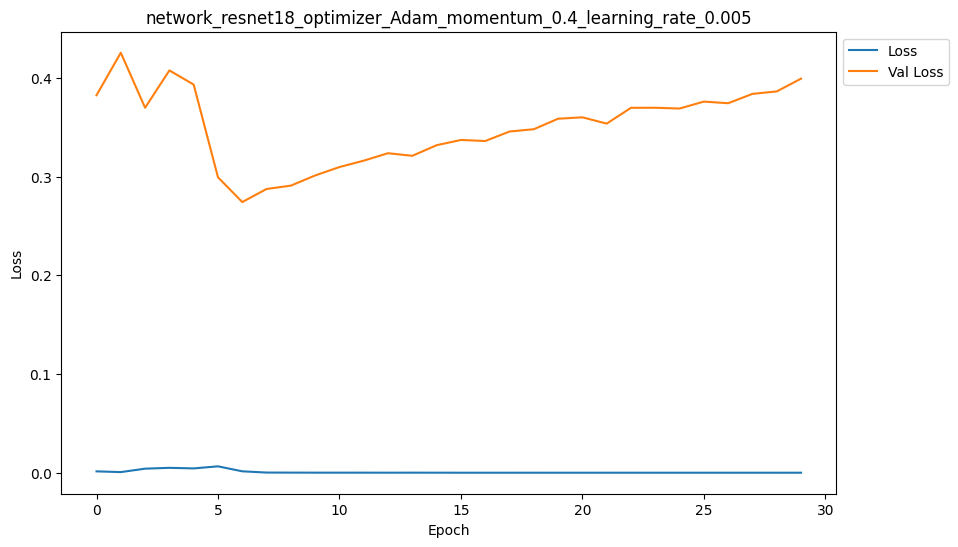

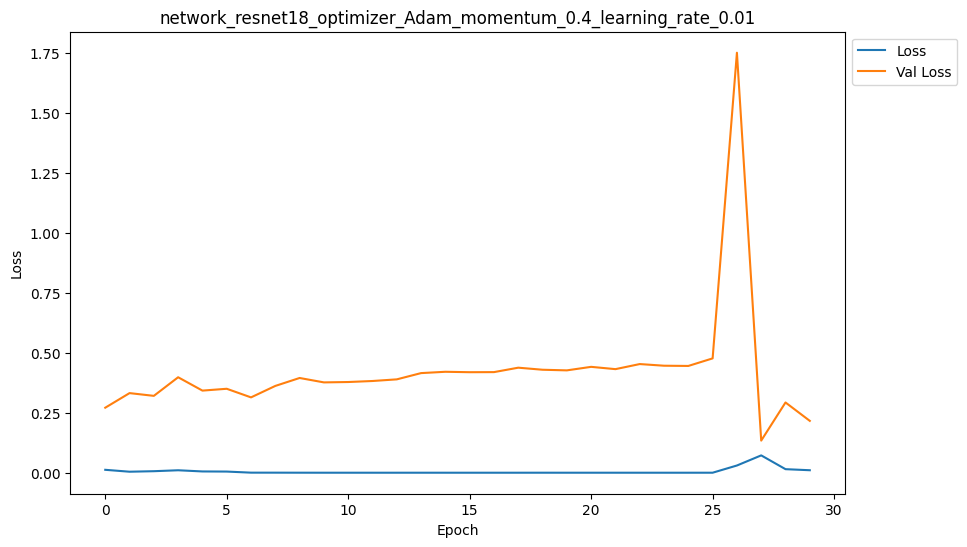

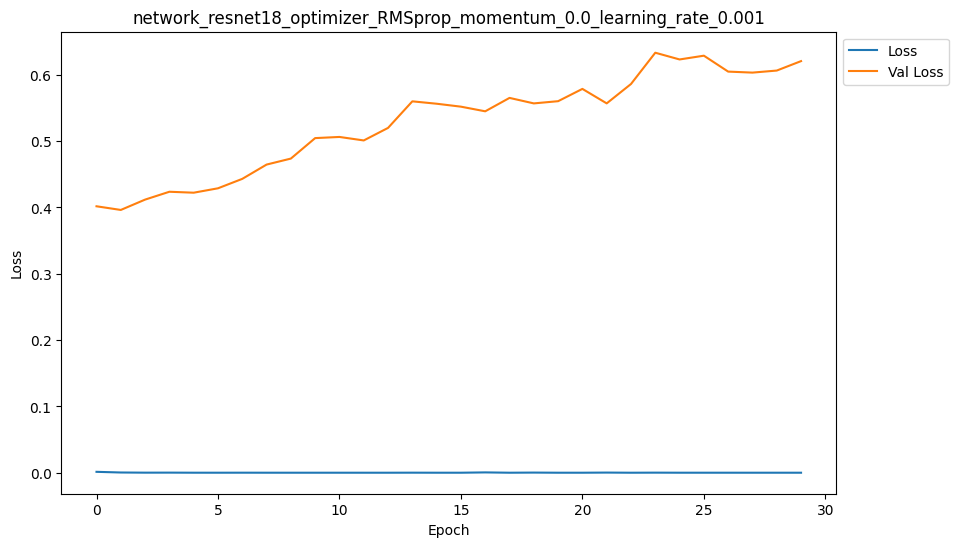

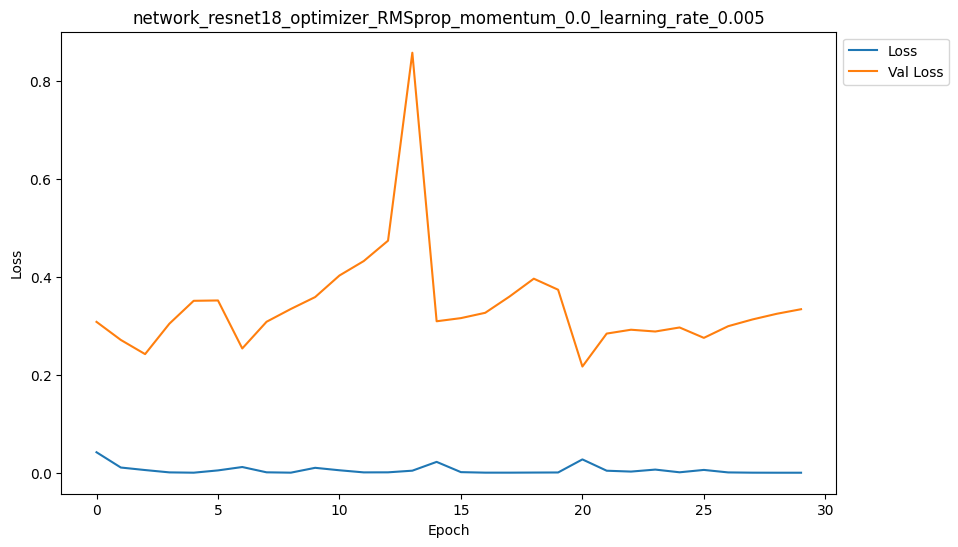

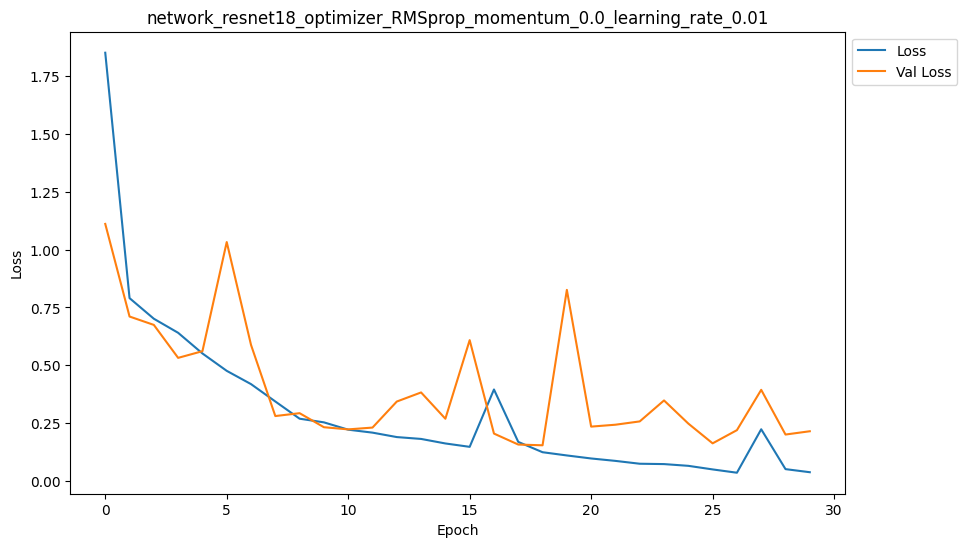

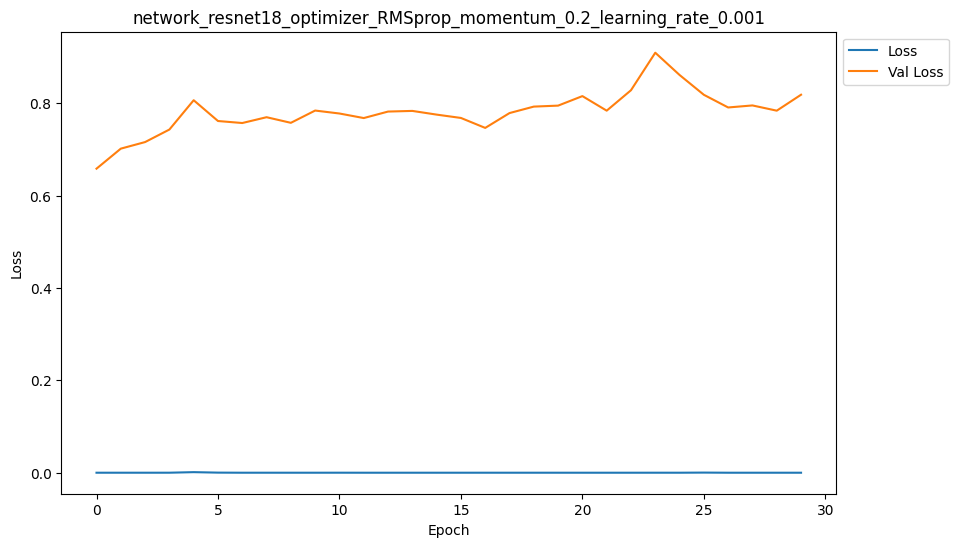

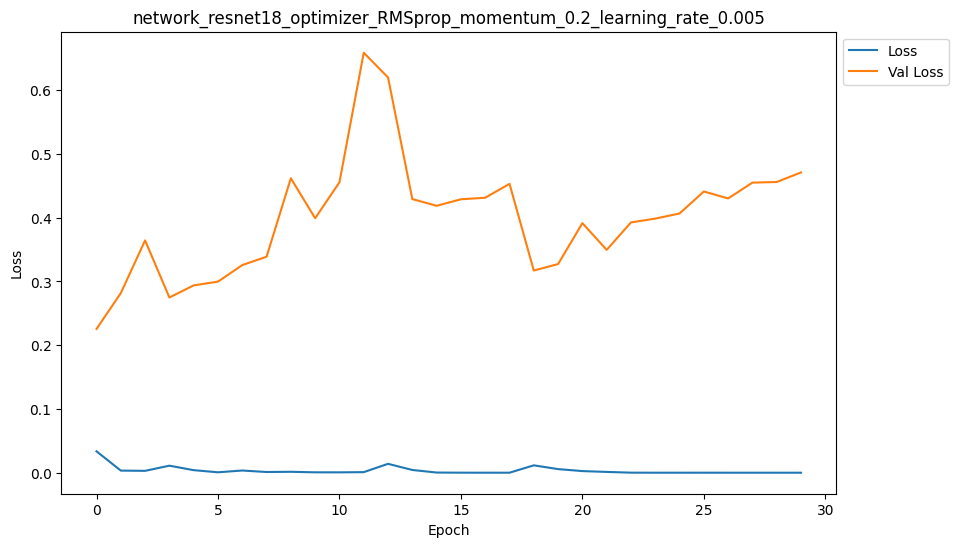

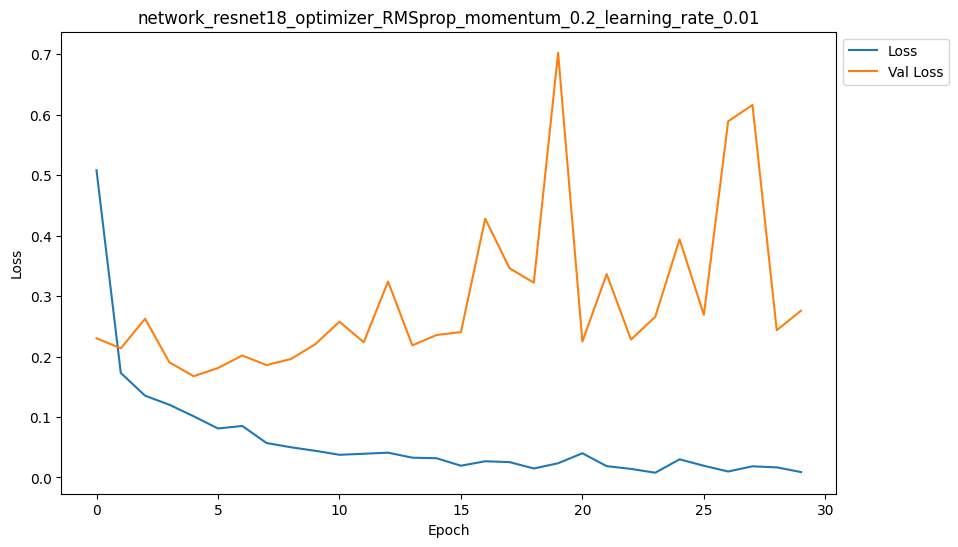

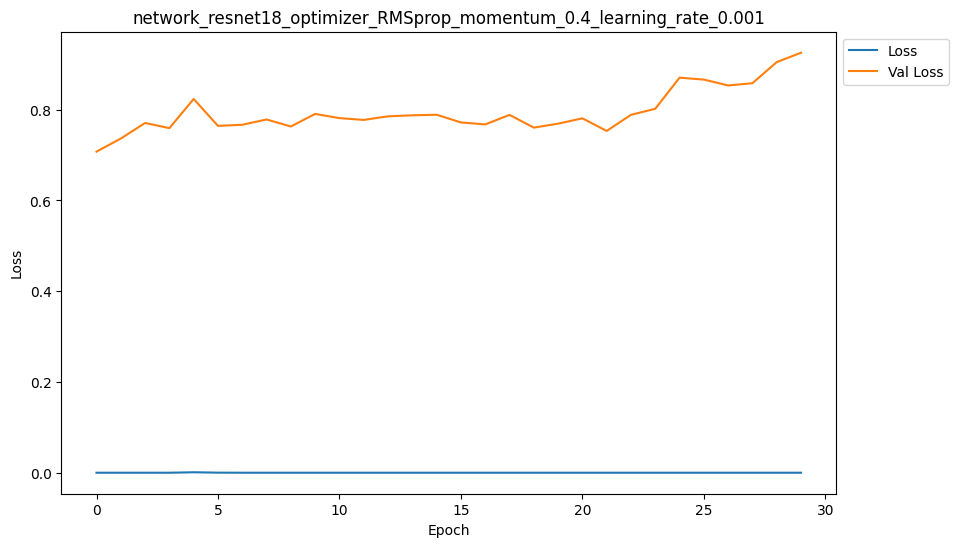

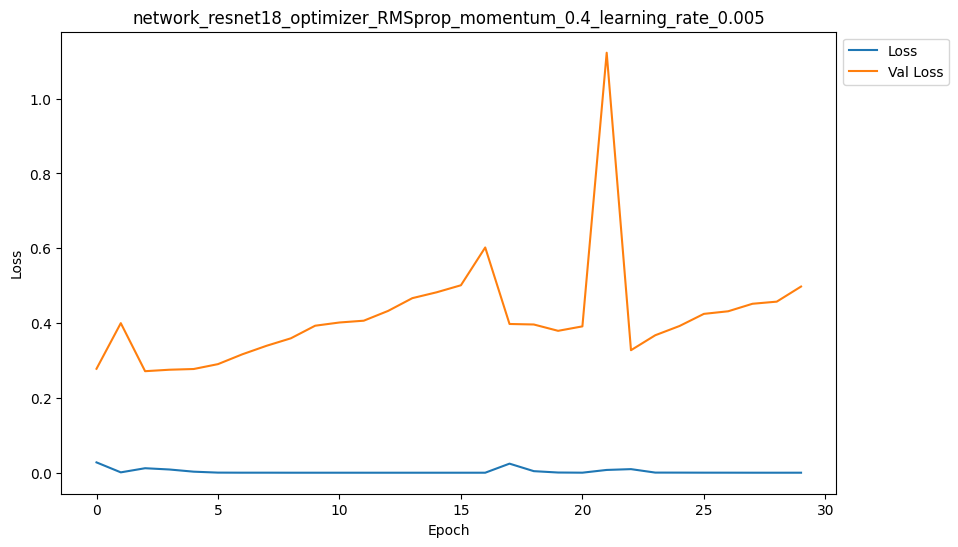

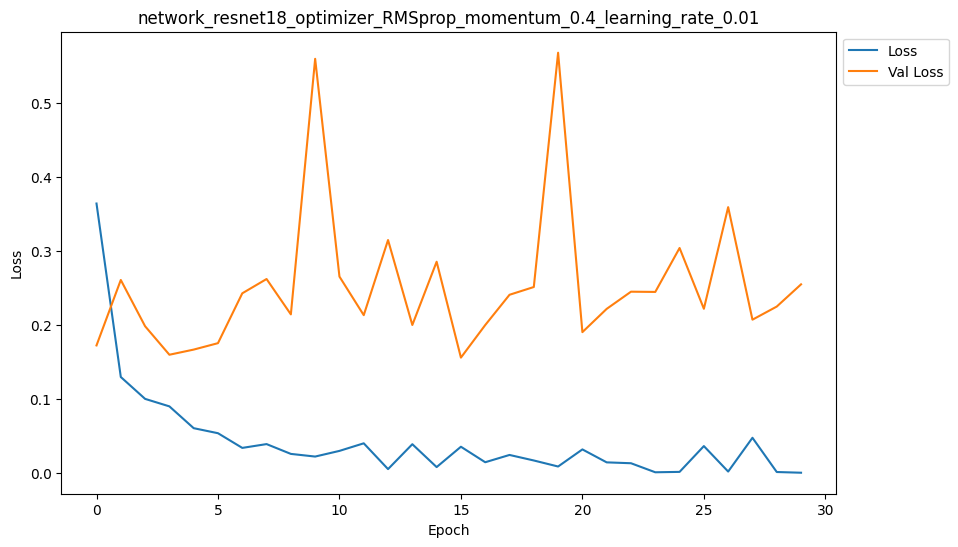

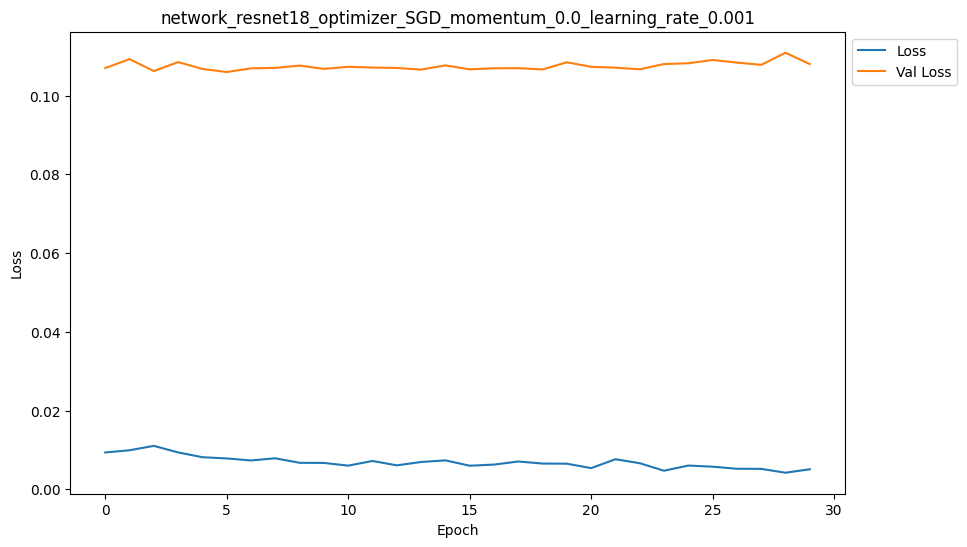

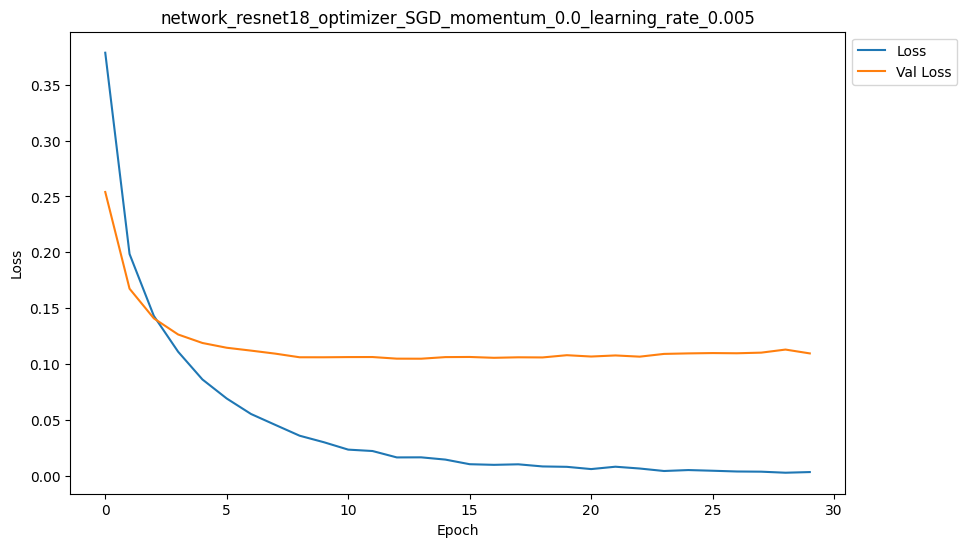

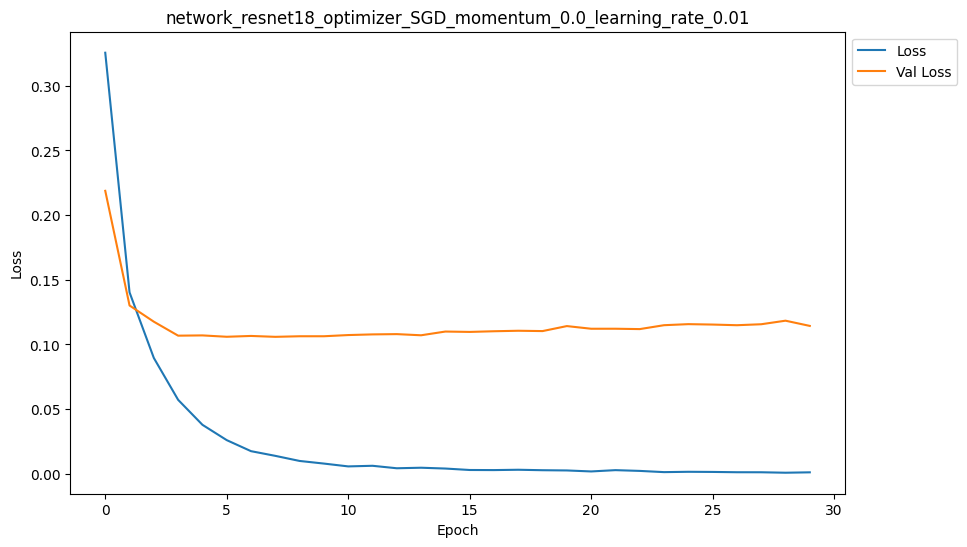

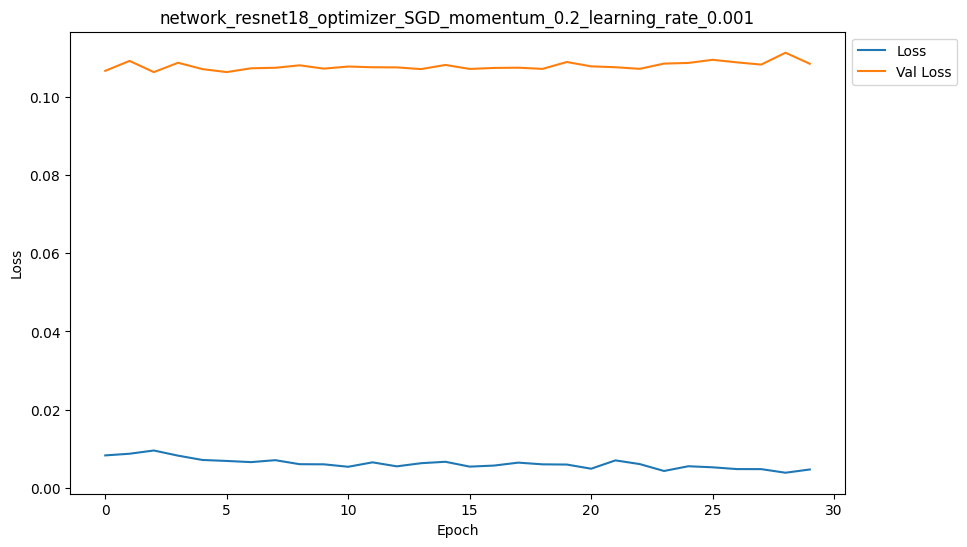

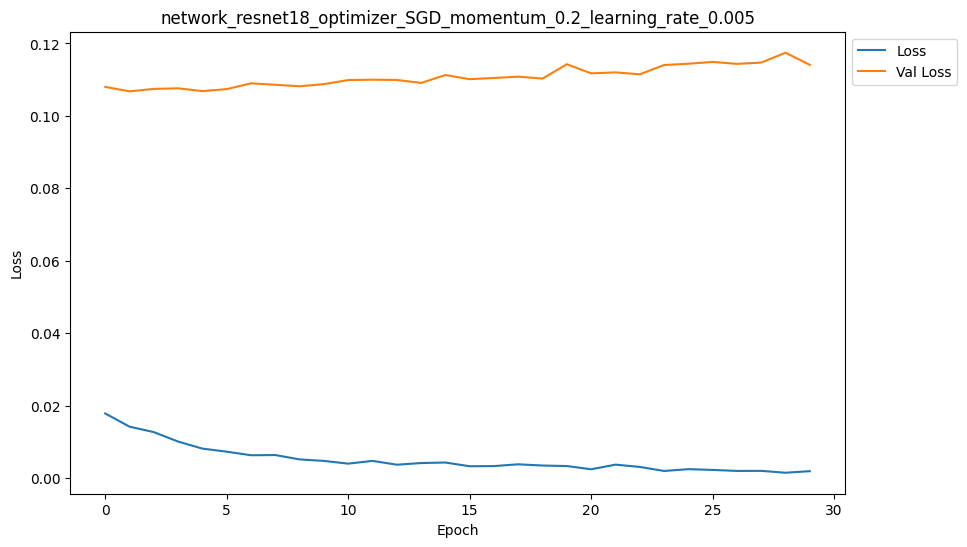

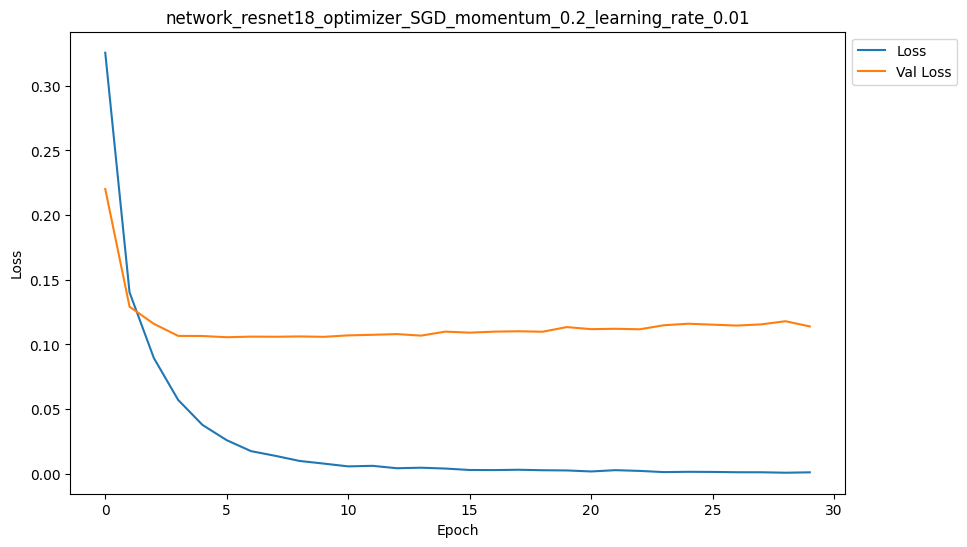

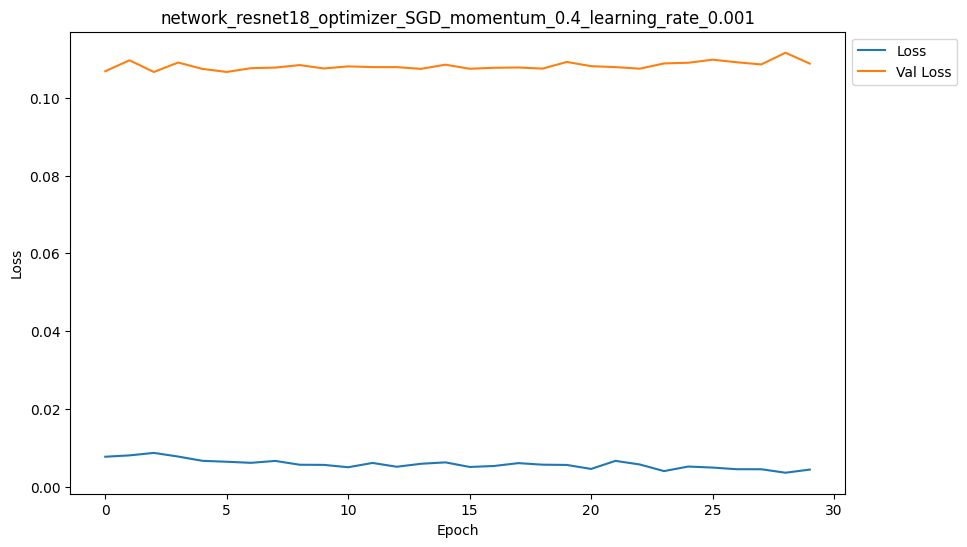

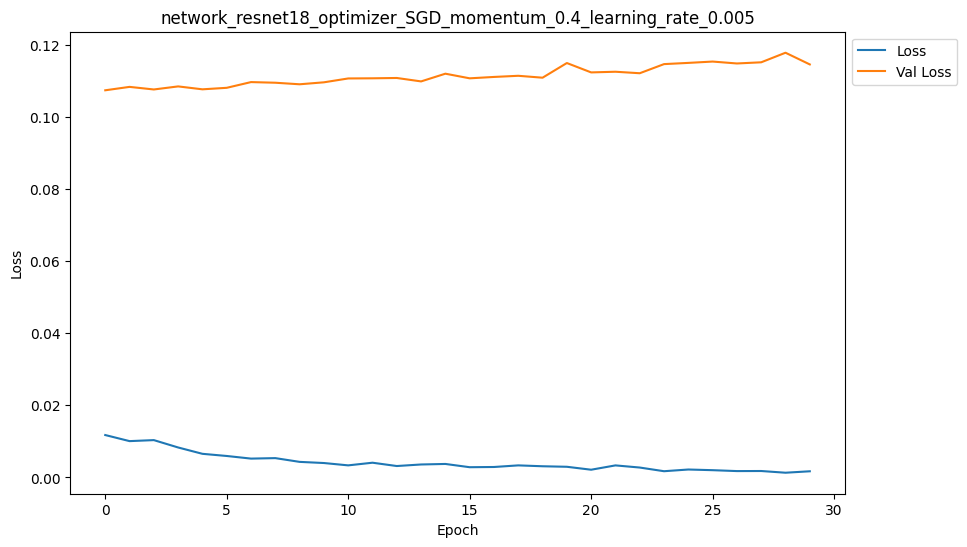

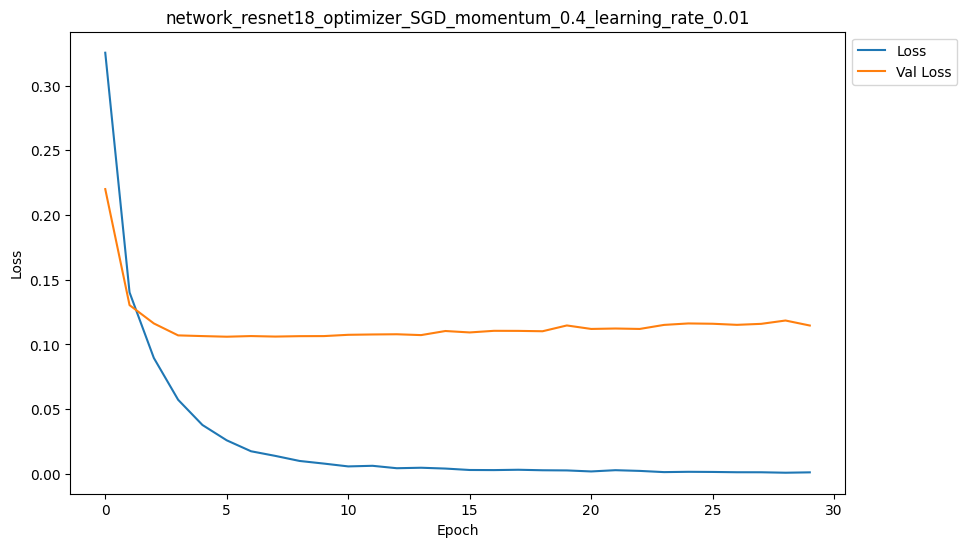

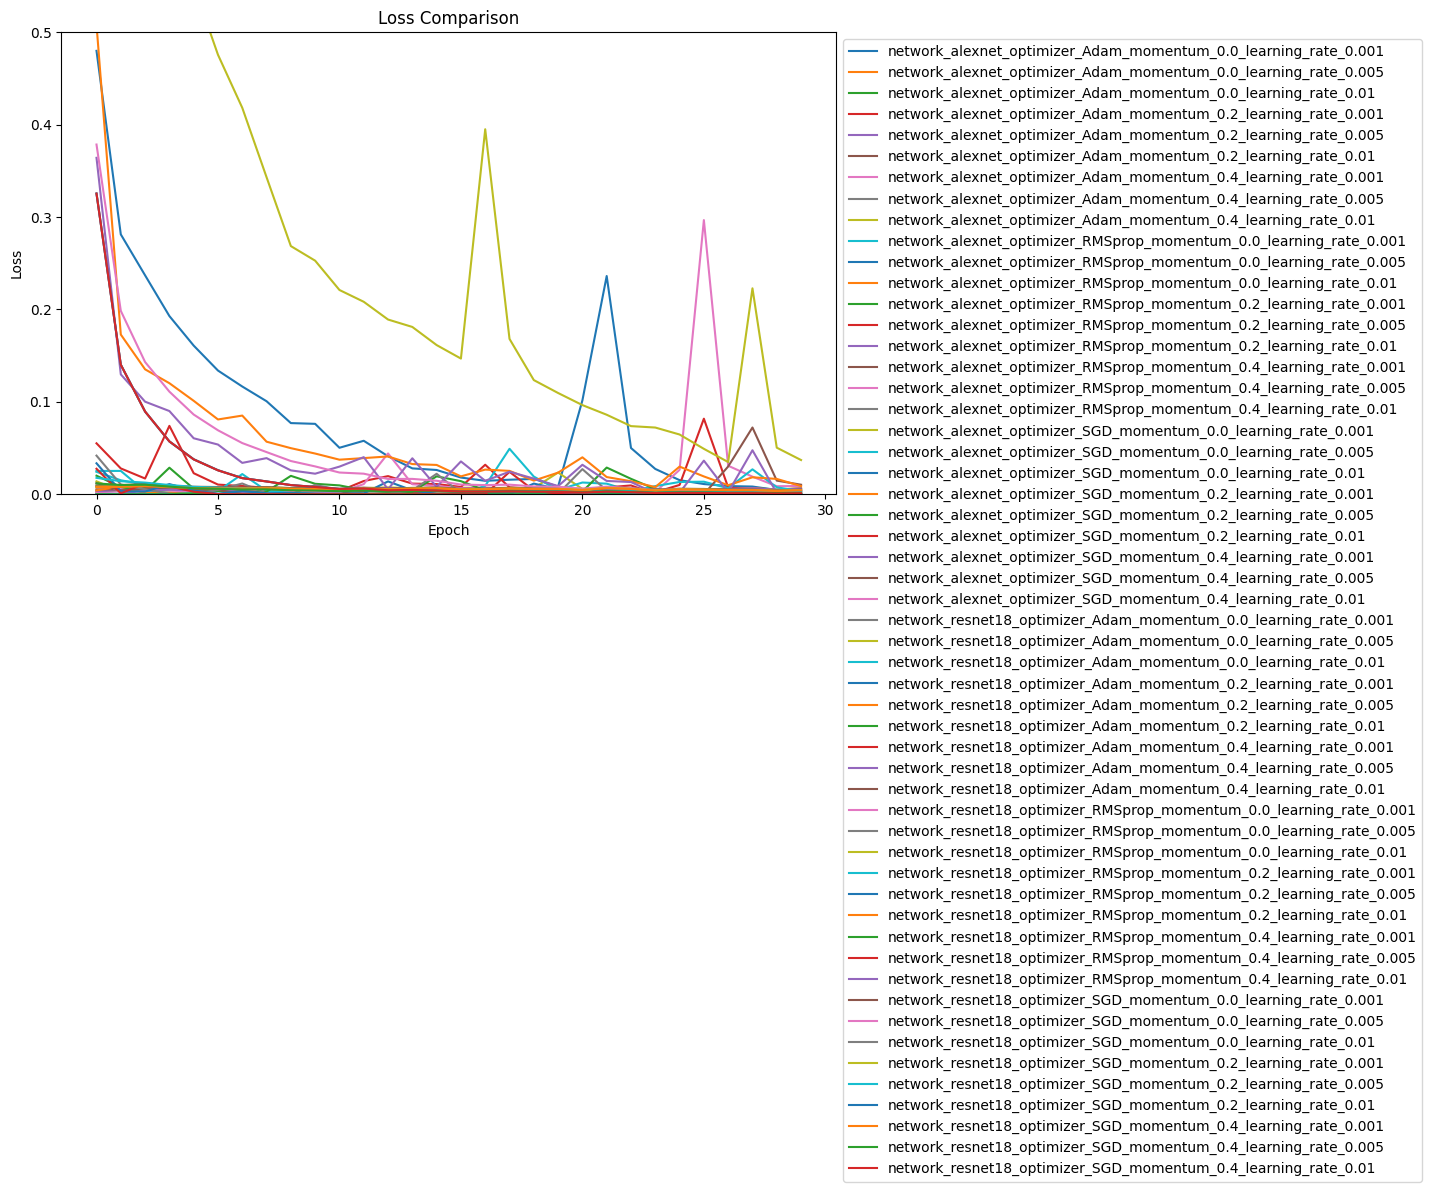

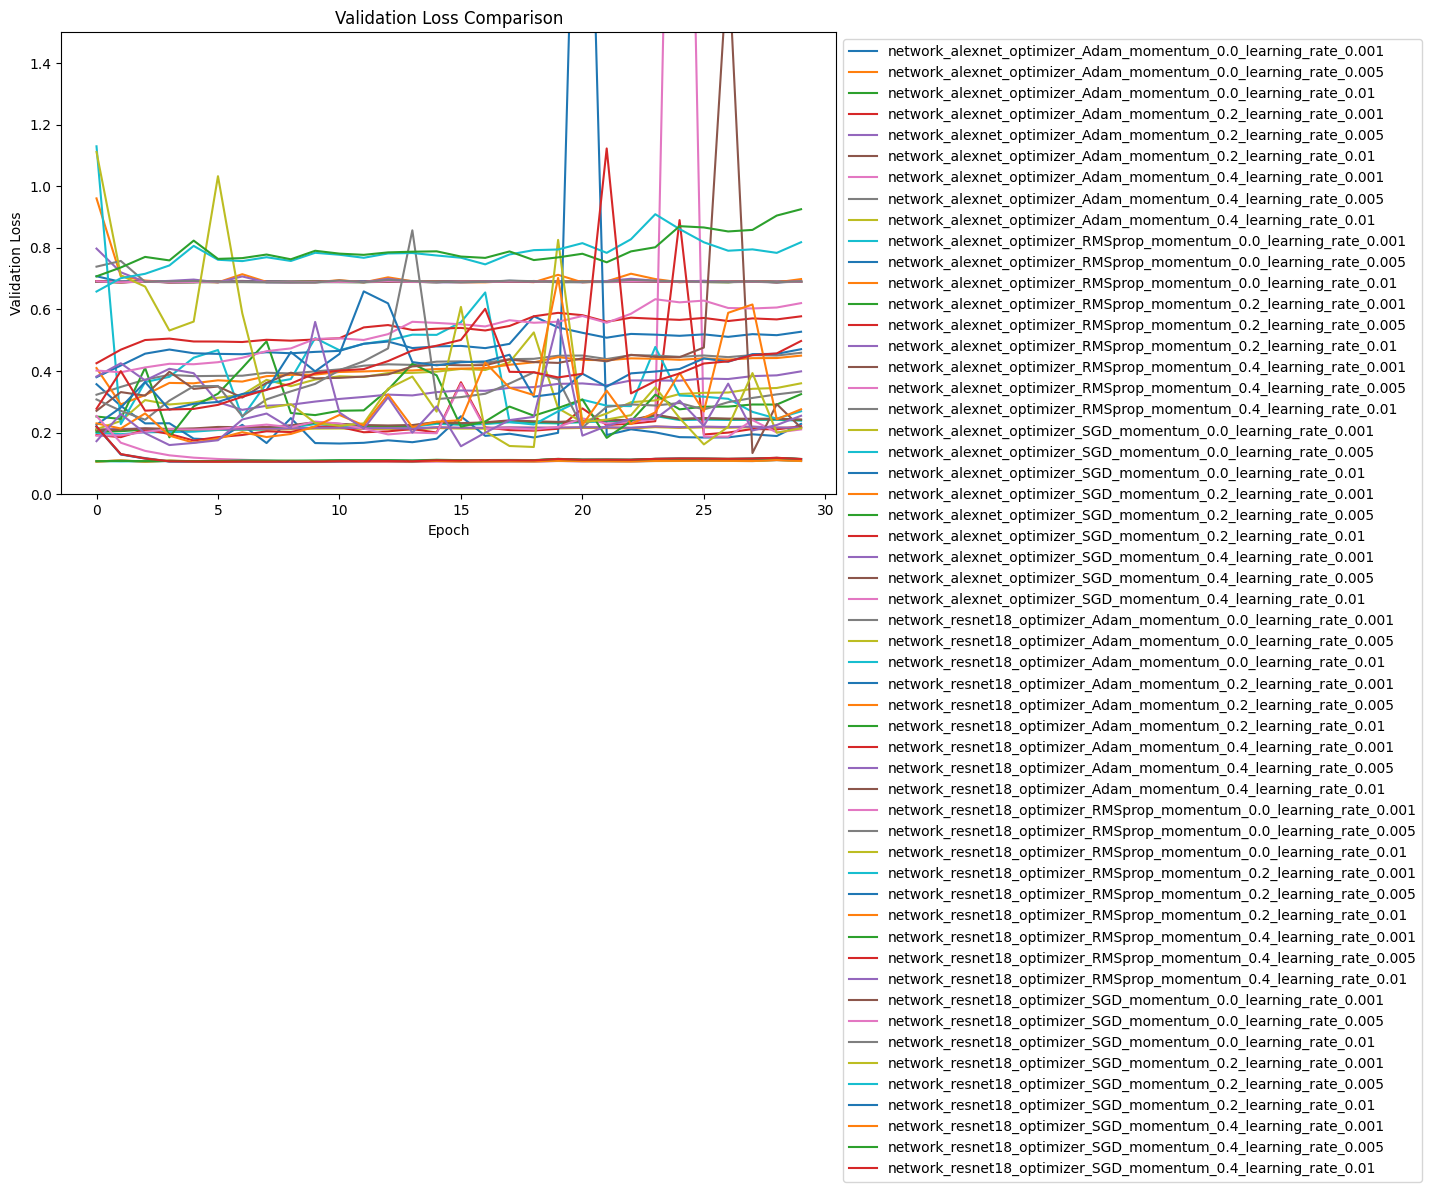

In [49]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory where your .tsv files are located
directory = f"C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/"

# Initialize lists to store loss and val_loss data
all_loss_data = []
all_val_loss_data = []
plot_labels = []  # Store the labels for the individual plots

# Loop through the .tsv files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.tsv') and 'vgg16' not in filename:
        file_path = os.path.join(directory, filename)

        # Extract information from the filename
        file_parts = filename.split('_')
        network_name = file_parts[0]
        optimizer_name = file_parts[1]
        momentum_number = file_parts[2]
        learning_rate_number = file_parts[3].replace('.tsv', '')

        # Read the TSV file into a DataFrame
        df = pd.read_csv(file_path, delimiter='\t')

        # Extract loss and val_loss columns
        loss_data = df['loss']
        val_loss_data = df['val_loss']

        # Append the data to the respective lists
        all_loss_data.append(loss_data)
        all_val_loss_data.append(val_loss_data)

        # Create individual line graphs for each '.tsv' file with labels
        plt.figure(figsize=(10, 6))
        plt.plot(loss_data, label='Loss')
        plt.plot(val_loss_data, label='Val Loss')
        title = f'network_{network_name}_optimizer_{optimizer_name}_momentum_{momentum_number}_learning_rate_{learning_rate_number}'
        plt.title(title)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        # Store the label for the individual plot
        plot_labels.append(title)

# Create a plot for all 'loss' data on the same axis with labels
plt.figure(figsize=(10, 6))
for loss_data, label in zip(all_loss_data, plot_labels):
    plt.plot(loss_data, label=label)
plt.title('Loss Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.5)  # Limit the y-axis for 'Loss'
plt.show()

# Create a plot for all 'val_loss' data on the same axis with labels
plt.figure(figsize=(10, 6))
for val_loss_data, label in zip(all_val_loss_data, plot_labels):
    plt.plot(val_loss_data, label=label)
plt.title('Validation Loss Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.ylim(0, 1.5)  # Limit the y-axis for 'Validation Loss'
plt.show()


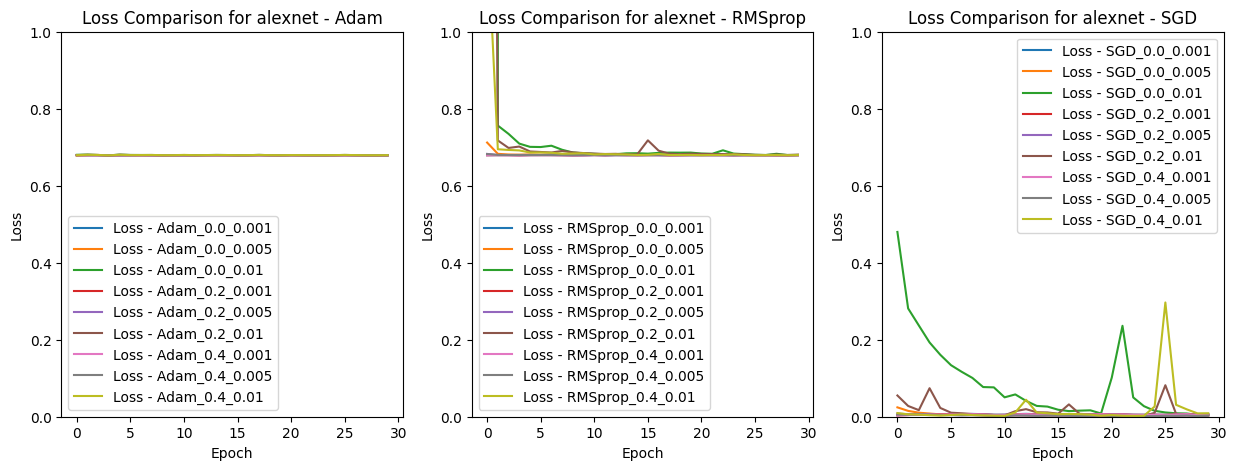

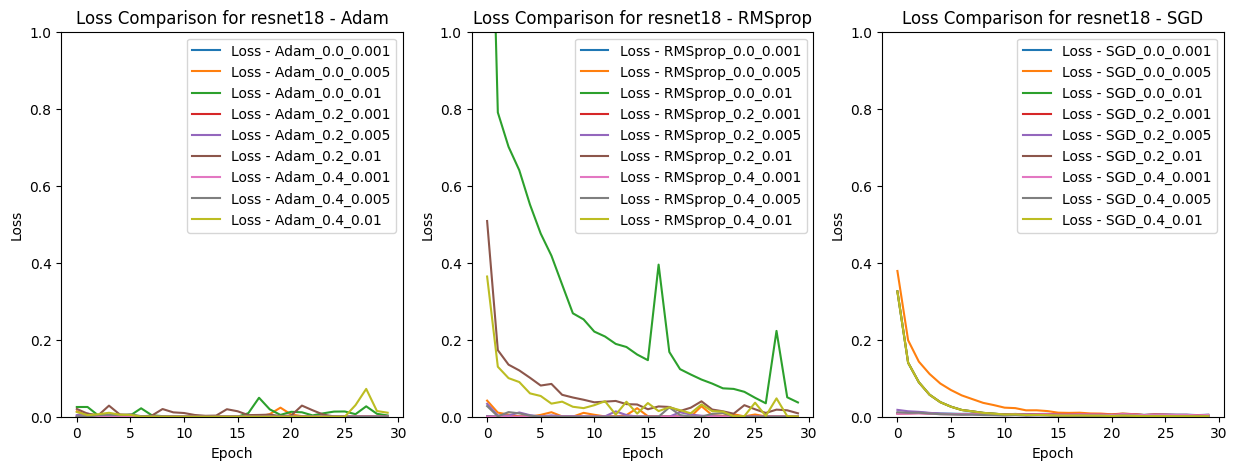

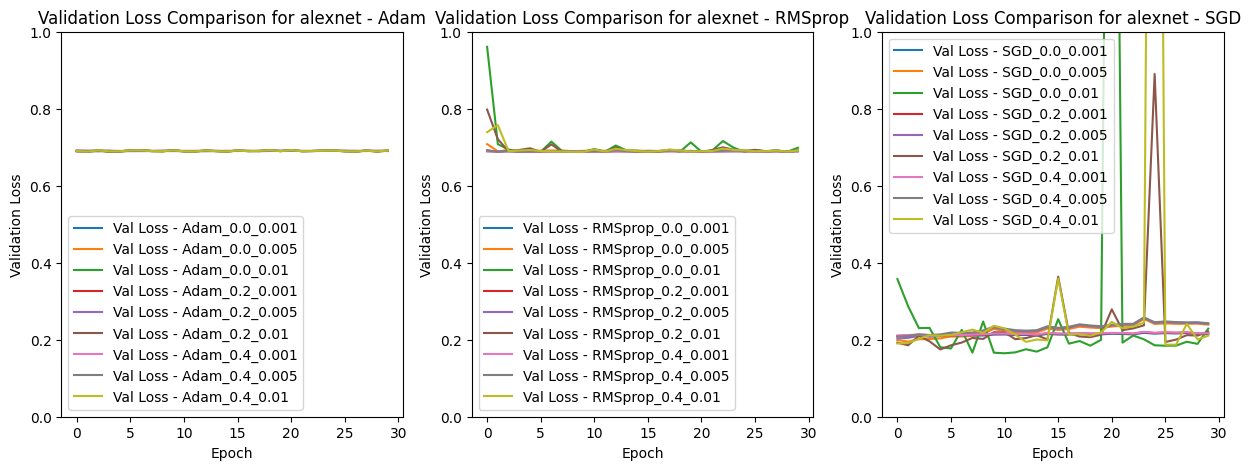

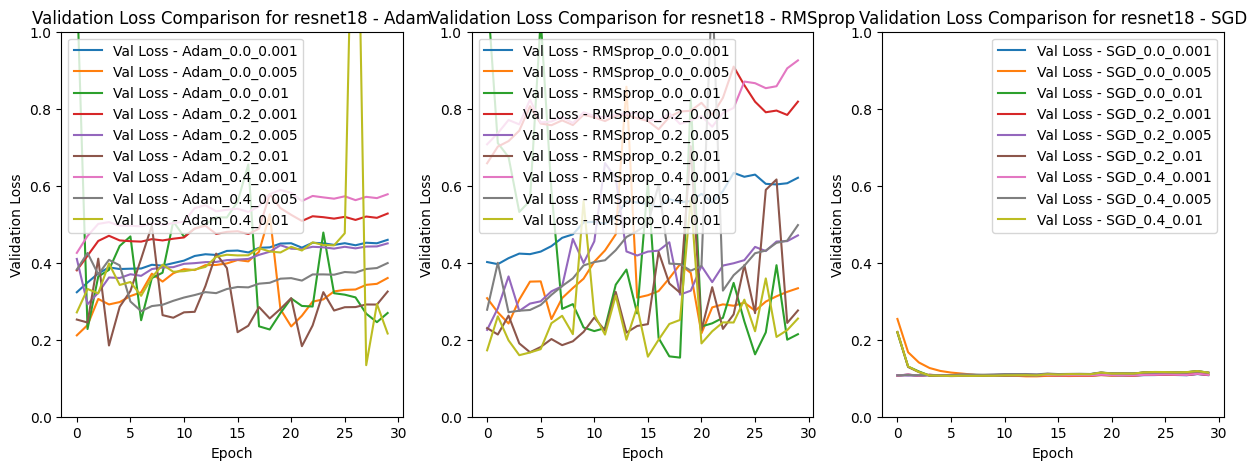

In [58]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory where your .tsv files are located
directory = f"C:/Users/saori/Desktop/NTU stuff/Courses/Year 4 Sem 1/CZ4042 Neural Network & Deep Learning/group_project/cnn/saves/"

# Initialize dictionaries to store loss and val_loss data by network
loss_by_network = {}
val_loss_by_network = {}

# Loop through the .tsv files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.tsv') and 'vgg16' not in filename:
        file_path = os.path.join(directory, filename)

        # Extract information from the filename
        file_parts = filename.split('_')
        optimizer_name = file_parts[1]
        momentum_number = file_parts[2]
        learning_rate_number = file_parts[3].replace('.tsv', '')
        network_name = file_parts[0]

        # Read the TSV file into a DataFrame
        df = pd.read_csv(file_path, delimiter='\t')

        # Extract loss and val_loss columns
        loss_data = df['loss']
        val_loss_data = df['val_loss']

        # # Check if all values are above 0.6
        # if all(val > 0.6 for val in loss_data) and all(val > 0.6 for val in val_loss_data):
        #     continue  # Skip this graph

        # Create a label in the desired format
        label = f'{optimizer_name}_{momentum_number}_{learning_rate_number}'

        # Check if the network exists in the dictionaries, and if not, create a new entry
        if network_name not in loss_by_network:
            loss_by_network[network_name] = {}
            val_loss_by_network[network_name] = {}

        if optimizer_name not in loss_by_network[network_name]:
            loss_by_network[network_name][optimizer_name] = {'labels': [], 'loss_data': []}
            val_loss_by_network[network_name][optimizer_name] = {'labels': [], 'val_loss_data': []}

        # Append the data to the respective dictionaries
        loss_by_network[network_name][optimizer_name]['labels'].append(label)
        loss_by_network[network_name][optimizer_name]['loss_data'].append(loss_data)
        val_loss_by_network[network_name][optimizer_name]['labels'].append(label)
        val_loss_by_network[network_name][optimizer_name]['val_loss_data'].append(val_loss_data)

# Create separate subplots for each network's 'loss' data
for network_name, optimizer_data in loss_by_network.items():
    num_optimizers = len(optimizer_data)
    fig, axs = plt.subplots(1, num_optimizers, figsize=(15, 5))

    for i, (optimizer_name, data) in enumerate(optimizer_data.items()):
        ax = axs[i]
        for label, loss_data in zip(data['labels'], data['loss_data']):
            ax.plot(loss_data, label=f'Loss - {label}')
        ax.set_title(f'Loss Comparison for {network_name} - {optimizer_name}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_ylim(0, 1)  # Limit the y-axis to (0, 1)
        ax.legend()

    plt.show()

# Create separate subplots for each network's 'val_loss' data
for network_name, optimizer_data in val_loss_by_network.items():
    num_optimizers = len(optimizer_data)
    fig, axs = plt.subplots(1, num_optimizers, figsize=(15, 5))

    for i, (optimizer_name, data) in enumerate(optimizer_data.items()):
        ax = axs[i]
        for label, val_loss_data in zip(data['labels'], data['val_loss_data']):
            ax.plot(val_loss_data, label=f'Val Loss - {label}')
        ax.set_title(f'Validation Loss Comparison for {network_name} - {optimizer_name}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Validation Loss')
        ax.set_ylim(0, 1)  # Limit the y-axis to (0, 1)
        ax.legend()

    plt.show()


In [12]:
# import shutil
# shutil.rmtree('./saves', ignore_errors=True)